# 1 Introduction
This project is based on the criteria from the Kaggle "I’m Something of a Painter Myself Competition:

https://www.kaggle.com/competitions/gan-getting-started

## 1.1 Problem Description
The goal of this competition is to develop a generative adversarial network (GAN) capable of converting standard photographic images into artwork in the style of Claude Monet. This task involves image-to-image translation, where the model learns to mimic the visual characteristics of Monet's paintings while preserving the underlying structure of the input photographs. The project leverages GAN architectures, particularly CycleGAN, to address this style transfer problem.

## 1.2 Dataset Import
The data for this competition can be found at:

https://www.kaggle.com/competitions/gan-getting-started/data

### Data Import
The dataset consists of two primary sets of images:

- Monet paintings: Images of original artworks by Claude Monet.

- Photographic images: Standard landscape photographs for conversion into Monet's artistic style.

These images are stored in TFRecord format to streamline the loading and preprocessing pipeline.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os

In [ ]:
monet_path = 'path_to_extract/monet_tfrec/'
photo_path = 'path_to_extract/photo_tfrec/'

monet_files = os.listdir(monet_path)
photo_files = os.listdir(photo_path)

# Print the counts of each type of file
print(f"Number of Monet files: {len(monet_files)}")
print(f"Number of Photo files: {len(photo_files)}")

for file in monet_files + photo_files:
    file_path = os.path.join(monet_path if file in monet_files else photo_path, file)
    print(f"File: {file}, Size: {os.path.getsize(file_path)} bytes")


Number of Monet files: 5
Number of Photo files: 20
File: monet00-60.tfrec, Size: 2234695 bytes
File: monet16-60.tfrec, Size: 2028261 bytes
File: monet08-60.tfrec, Size: 1966705 bytes
File: monet04-60.tfrec, Size: 2044018 bytes
File: monet12-60.tfrec, Size: 1984259 bytes
File: photo10-352.tfrec, Size: 13678565 bytes
File: photo04-352.tfrec, Size: 13826551 bytes
File: photo09-352.tfrec, Size: 13683551 bytes
File: photo16-352.tfrec, Size: 13487236 bytes
File: photo02-352.tfrec, Size: 13296290 bytes
File: photo05-352.tfrec, Size: 14053476 bytes
File: photo11-352.tfrec, Size: 13881629 bytes
File: photo08-352.tfrec, Size: 13731125 bytes
File: photo03-352.tfrec, Size: 13425298 bytes
File: photo17-352.tfrec, Size: 13921276 bytes
File: photo12-352.tfrec, Size: 13539765 bytes
File: photo06-352.tfrec, Size: 13661631 bytes
File: photo19-350.tfrec, Size: 13607765 bytes
File: photo14-352.tfrec, Size: 13844390 bytes
File: photo00-352.tfrec, Size: 13769347 bytes
File: photo07-352.tfrec, Size: 13535765

# 2 Exploratory Data Analysis (EDA)

## 2.1 Dataset Overview

The dataset provides high-quality images that serve as the basis for training the GAN model. The Monet images act as the target style, while the photographic images serve as the input for transformation.

Key characteristics of the dataset include:

- Number of Images:

    - Monet paintings: 300 images

    - Photographic images: 7,038 images

- Image Format:

    - All images are stored in TFRecord format for efficient streaming during training.

    - Images are encoded as JPEG and decoded with 3 channels (RGB), maintaining full color fidelity.

- Image Dimensions:

    - Each image has a fixed size of 256×256 pixels, ensuring uniformity for training the model and reducing the need for resizing or cropping.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def verify_tfrec_images(file_paths, dataset_name):
    errors = []
    total = 0

    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }

    def _parse_function(example_proto):
        return tf.io.parse_single_example(example_proto, feature_description)

    for tfrec_file in file_paths:
        full_path = os.path.join(dataset_name, tfrec_file)
        raw_dataset = tf.data.TFRecordDataset(full_path)

        for raw_record in raw_dataset:
            total += 1
            example = tf.io.parse_single_example(raw_record, feature_description)
            image = tf.image.decode_jpeg(example['image'], channels=3)
            if image.shape != (256, 256, 3):
                errors.append((tfrec_file, image.shape))

    print(f"\nChecked {total} images in '{dataset_name}'.")
    if errors:
        print(f"Found {len(errors)} mismatches:")
        for file, shape in errors:
            print(f"  - File: {file}, Image shape: {shape}")
    else:
        print("All images are 256x256 and RGB")

verify_tfrec_images(monet_files, monet_path)
verify_tfrec_images(photo_files, photo_path)


2025-04-29 04:55:25.831383: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-04-29 04:55:25.881294: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-29 04:55:25.935010: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-29 04:55:26.043903: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Checked 300 images in 'path_to_extract/monet_tfrec/'.
All images are 256x256 and RGB


2025-04-29 04:55:27.000754: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-29 04:55:29.433459: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Checked 7038 images in 'path_to_extract/photo_tfrec/'.
All images are 256x256 and RGB


2025-04-29 04:55:32.219244: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


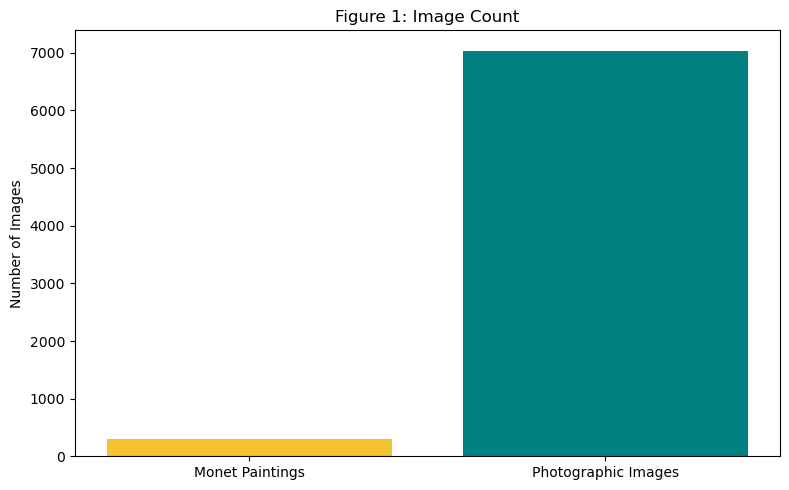

In [ ]:
# Function to count total images in all TFRecord files in a given path
def count_images_in_tfrec(file_list, dir_path):
    count = 0
    for filename in file_list:
        tfrec_path = os.path.join(dir_path, filename)
        dataset = tf.data.TFRecordDataset(tfrec_path)
        count += sum(1 for _ in dataset)
    return count

# Count images
num_monet_images = count_images_in_tfrec(monet_files, monet_path)
num_photo_images = count_images_in_tfrec(photo_files, photo_path)

labels = ['Monet Paintings', 'Photographic Images']
values = [num_monet_images, num_photo_images]

colors = ['#F4C430', '#008080']  # saffron and teal

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=colors)
plt.title('Figure 1: Image Count')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()


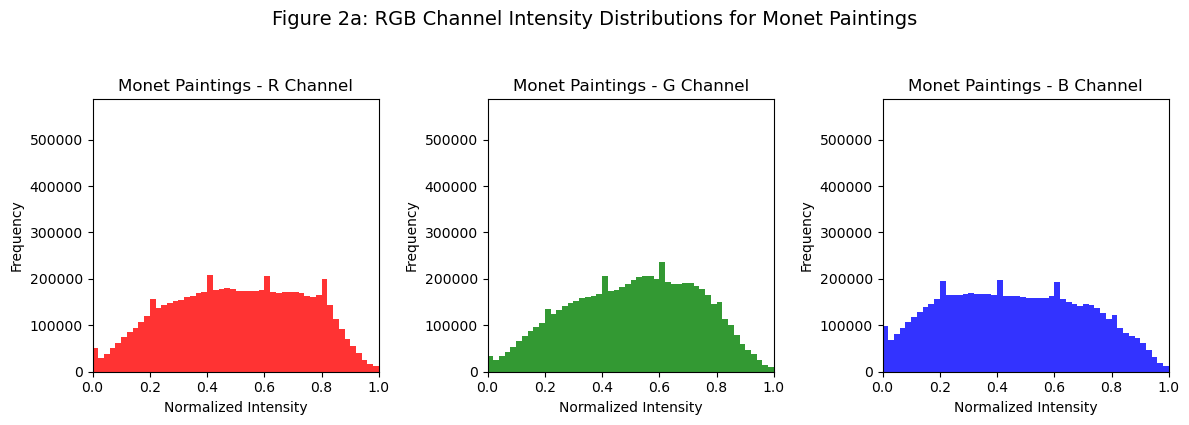

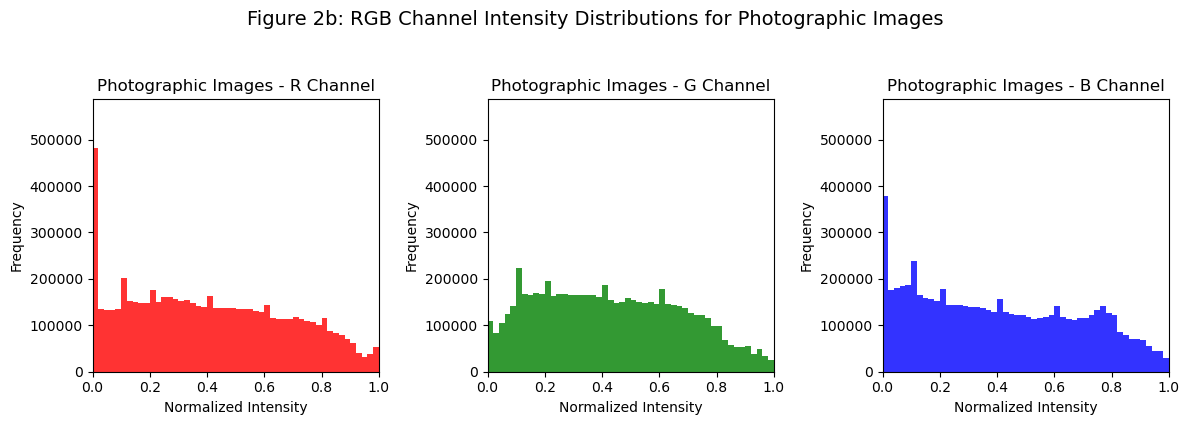

In [ ]:
# Function to decode images from TFRecord files
def extract_rgb_values(file_list, dir_path, max_images=100):
    rgb_values = {'r': [], 'g': [], 'b': []}

    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }

    def _parse_function(example_proto):
        return tf.io.parse_single_example(example_proto, feature_description)

    image_count = 0
    for filename in file_list:
        if image_count >= max_images:
            break
        tfrec_path = os.path.join(dir_path, filename)
        dataset = tf.data.TFRecordDataset(tfrec_path)
        for record in dataset:
            if image_count >= max_images:
                break
            example = tf.io.parse_single_example(record, feature_description)
            image = tf.image.decode_jpeg(example['image'], channels=3)
            image = tf.cast(image, tf.float32) / 255.0  # normalize
            r, g, b = tf.split(image, num_or_size_splits=3, axis=-1)
            rgb_values['r'].extend(tf.reshape(r, [-1]).numpy())
            rgb_values['g'].extend(tf.reshape(g, [-1]).numpy())
            rgb_values['b'].extend(tf.reshape(b, [-1]).numpy())
            image_count += 1

    return rgb_values

# Extract RGB values
monet_rgb = extract_rgb_values(monet_files, monet_path, max_images=100)
photo_rgb = extract_rgb_values(photo_files, photo_path, max_images=100)

# Determine global x and y axis limits
def get_rgb_histogram_limits(rgb_dicts, bins=50):
    all_values = {c: [] for c in ['r', 'g', 'b']}
    max_y = 0

    for rgb in rgb_dicts:
        for c in ['r', 'g', 'b']:
            all_values[c].extend(rgb[c])

    xlims = (0, 1)  # Normalized intensity range
    ylims = {}
    for c in ['r', 'g', 'b']:
        counts, _ = np.histogram(all_values[c], bins=bins)
        ylims[c] = max(counts)
        if ylims[c] > max_y:
            max_y = ylims[c]

    return xlims, (0, max_y * 1.1)  # add a little headroom

xlim, ylim = get_rgb_histogram_limits([monet_rgb, photo_rgb])

def plot_rgb_distribution(rgb_values, title, figure_label, xlim, ylim):
    plt.figure(figsize=(12, 4))
    channel_colors = {'r': 'red', 'g': 'green', 'b': 'blue'}

    for i, channel in enumerate(['r', 'g', 'b']):
        plt.subplot(1, 3, i+1)
        plt.hist(rgb_values[channel], bins=50, color=channel_colors[channel], alpha=0.8)
        plt.title(f'{title} - {channel.upper()} Channel')
        plt.xlabel('Normalized Intensity')
        plt.ylabel('Frequency')
        plt.xlim(xlim)
        plt.ylim(ylim)

    plt.suptitle(f'Figure 2{figure_label}: RGB Channel Intensity Distributions for {title}', fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

plot_rgb_distribution(monet_rgb, "Monet Paintings", "a", xlim, ylim)
plot_rgb_distribution(photo_rgb, "Photographic Images", "b", xlim, ylim)


## 2.2 Data Preprocessing

Datasets were prepared for both domains (Monet paintings and photographs) using TFRecord files. Each image was decoded, resized to a standardized resolution of 256x256 pixels, and normalized to a range of [-1, 1] to match the input expectations of the CycleGAN model.

An optional augmentation pipeline was also implemented, applying random horizontal flipping, brightness variation, contrast changes, saturation shifts, hue adjustments, and additive Gaussian noise. This data augmentation aimed to introduce greater variability into the training data, enhancing model robustness.

Two types of batch sizes were generated:

- Batch size 1: For training the CycleGAN with individual images, as is standard practice for unpaired image-to-image translation tasks.

- Batch size 8: For alternative training configurations where larger batch sizes could be tested.

Each dataset was batched, shuffled with a buffer of 1000 images to ensure good randomization, and prefetched for performance optimization during training. Shape verification was performed after each loading step to ensure data consistency, with all batches matching the expected shape (batch_size, 256, 256, 3).

Separate datasets were prepared both with and without data augmentation, allowing flexibility for experiments testing augmentation's effect on the final model performance.

In [ ]:
def scale_image(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1.0
    return image

def get_parse_and_decode_fn(feature_description):
    def _parse_and_decode(example_proto):
        example = tf.io.parse_single_example(example_proto, feature_description)
        image = tf.image.decode_jpeg(example['image'], channels=3)
        image = tf.image.resize(image, [256, 256])
        image = scale_image(image)
        return image
    return _parse_and_decode

def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1)
    image = image + noise

    return image

# Apply to both A (photos) and B (monets)
def preprocess_dataset(dataset):
    return dataset.map(lambda x: augment_image(x), num_parallel_calls=tf.data.AUTOTUNE)


def load_and_prepare_dataset(file_paths, dataset_dir, batch_size=1, augment=False, shuffle_buffer=1000, drop_remainder=True):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }

    tfrecord_paths = [os.path.join(dataset_dir, fname) for fname in file_paths]
    raw_dataset = tf.data.TFRecordDataset(tfrecord_paths)

    parse_and_decode_fn = get_parse_and_decode_fn(feature_description)
    dataset = raw_dataset.map(parse_and_decode_fn, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        dataset = dataset.map(lambda x: augment_image(x), num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
    dataset = dataset.shuffle(shuffle_buffer).prefetch(tf.data.AUTOTUNE)

    for images in dataset.take(1):
        print(f"Shape of batchsize-{batch_size} images: {images.shape}")
        break

    return dataset

# Create batch size 1 versions of the training datasets
monet_train_batchsize1 = load_and_prepare_dataset(monet_files, monet_path, batch_size=1, augment=False)
photo_train_batchsize1 =load_and_prepare_dataset(photo_files, photo_path, batch_size=1, augment=False)

monet_train_batchsize1 = monet_train_batchsize1.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
photo_train_batchsize1 = photo_train_batchsize1.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

# Shape check
for real_images_A, real_images_B in zip(photo_train_batchsize1, monet_train_batchsize1):
    print(f"Shape of real_images_A: {real_images_A.shape}")
    print(f"Shape of real_images_B: {real_images_B.shape}")
    break  # Just verify shape for one batch

for batch in monet_train_batchsize1.take(1):
    print(f"monet_train_batchsize1 batch shape: {batch.shape}")

for batch in photo_train_batchsize1.take(1):
    print(f"photo_train_batchsize1 batch shape: {batch.shape}")


Shape of batchsize-1 images: (1, 256, 256, 3)
Shape of batchsize-1 images: (1, 256, 256, 3)
Shape of real_images_A: (1, 256, 256, 3)
Shape of real_images_B: (1, 256, 256, 3)
monet_train_batchsize1 batch shape: (1, 256, 256, 3)
photo_train_batchsize1 batch shape: (1, 256, 256, 3)


In [ ]:
monet_train_batchsize1_with_aug = load_and_prepare_dataset(monet_files, monet_path, batch_size=1, augment=True)
photo_train_batchsize1_with_aug = load_and_prepare_dataset(photo_files, photo_path, batch_size=1, augment=True)

monet_train_batchsize1_with_aug = monet_train_batchsize1_with_aug.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
photo_train_batchsize1_with_aug = photo_train_batchsize1_with_aug.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

# Shape check
for real_images_A, real_images_B in zip(photo_train_batchsize1_with_aug, monet_train_batchsize1_with_aug):
    print(f"Shape of real_images_A: {real_images_A.shape}")
    print(f"Shape of real_images_B: {real_images_B.shape}")
    break  # Just verify shape for one batch

for batch in monet_train_batchsize1_with_aug.take(1):
    print(f"monet_train_batchsize1_with_aug batch shape: {batch.shape}")

for batch in photo_train_batchsize1_with_aug.take(1):
    print(f"photo_train_batchsize1 batch_with_aug shape: {batch.shape}")



Shape of batchsize-1 images: (1, 256, 256, 3)
Shape of batchsize-1 images: (1, 256, 256, 3)
Shape of real_images_A: (1, 256, 256, 3)
Shape of real_images_B: (1, 256, 256, 3)
monet_train_batchsize1_with_aug batch shape: (1, 256, 256, 3)
photo_train_batchsize1 batch_with_aug shape: (1, 256, 256, 3)


In [ ]:
# Create batch size 8 versions of the training datasets
monet_train_batchsize8 = load_and_prepare_dataset(monet_files, monet_path, batch_size=8, augment=False)
photo_train_batchsize8 =load_and_prepare_dataset(photo_files, photo_path, batch_size=8, augment=False)

monet_train_batchsize8 = monet_train_batchsize8.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
photo_train_batchsize8 = photo_train_batchsize8.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

# Shape check
for real_images_A, real_images_B in zip(photo_train_batchsize8, monet_train_batchsize8):
    print(f"Shape of real_images_A: {real_images_A.shape}")
    print(f"Shape of real_images_B: {real_images_B.shape}")
    break  # Just verify shape for one batch

for batch in monet_train_batchsize8.take(1):
    print(f"monet_train_batchsize8 batch shape: {batch.shape}")

for batch in photo_train_batchsize8.take(1):
    print(f"photo_train_batchsize8 batch shape: {batch.shape}")


Shape of batchsize-8 images: (8, 256, 256, 3)
Shape of batchsize-8 images: (8, 256, 256, 3)
Shape of real_images_A: (8, 256, 256, 3)
Shape of real_images_B: (8, 256, 256, 3)
monet_train_batchsize8 batch shape: (8, 256, 256, 3)
photo_train_batchsize8 batch shape: (8, 256, 256, 3)


In [ ]:
monet_train_batchsize8_with_aug = load_and_prepare_dataset(monet_files, monet_path, batch_size=8, augment=True)
photo_train_batchsize8_with_aug = load_and_prepare_dataset(photo_files, photo_path, batch_size=8, augment=True)

monet_train_batchsize8_with_aug = monet_train_batchsize8_with_aug.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
photo_train_batchsize8_with_aug = photo_train_batchsize8_with_aug.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

# Quick shape check
for real_images_A, real_images_B in zip(photo_train_batchsize8_with_aug, monet_train_batchsize8_with_aug):
    print(f"Shape of real_images_A: {real_images_A.shape}")
    print(f"Shape of real_images_B: {real_images_B.shape}")
    break  # Just verify shape for one batch

for batch in monet_train_batchsize8_with_aug.take(1):
    print(f"monet_train_batchsize8_with_aug batch shape: {batch.shape}")

for batch in photo_train_batchsize8_with_aug.take(1):
    print(f"photo_train_batchsize8_with_aug batch shape: {batch.shape}")



Shape of batchsize-8 images: (8, 256, 256, 3)
Shape of batchsize-8 images: (8, 256, 256, 3)
Shape of real_images_A: (8, 256, 256, 3)
Shape of real_images_B: (8, 256, 256, 3)
monet_train_batchsize1 batch shape: (8, 256, 256, 3)
photo_train_batchsize1 batch shape: (8, 256, 256, 3)


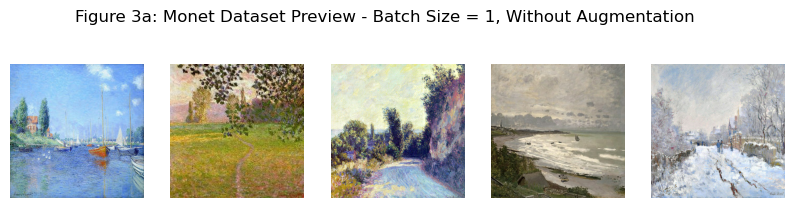

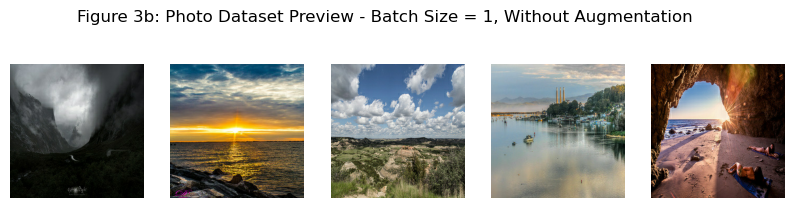

In [ ]:
def show_image_batchsize1(dataset, title, n=5):
    plt.figure(figsize=(n * 2, 2.5))
    for i, batch in enumerate(dataset.take(n)):
        image = batch[0]  # Since batch size is 1
        image_display = (image + 1.0) / 2.0  # Rescale from [-1, 1] to [0, 1]
        plt.subplot(1, n, i + 1)
        plt.imshow(image_display)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_image_batchsize1(monet_train_batchsize1, "Figure 3a: Monet Dataset Preview - Batch Size = 1, Without Augmentation")
show_image_batchsize1(photo_train_batchsize1, "Figure 3b: Photo Dataset Preview - Batch Size = 1, Without Augmentation")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14780682..1.2443838].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.23351246..1.2090102].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.110241234..1.074685].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.022484183..1.1522331].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19178385..1.1806116].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24093741..1.3038335].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0

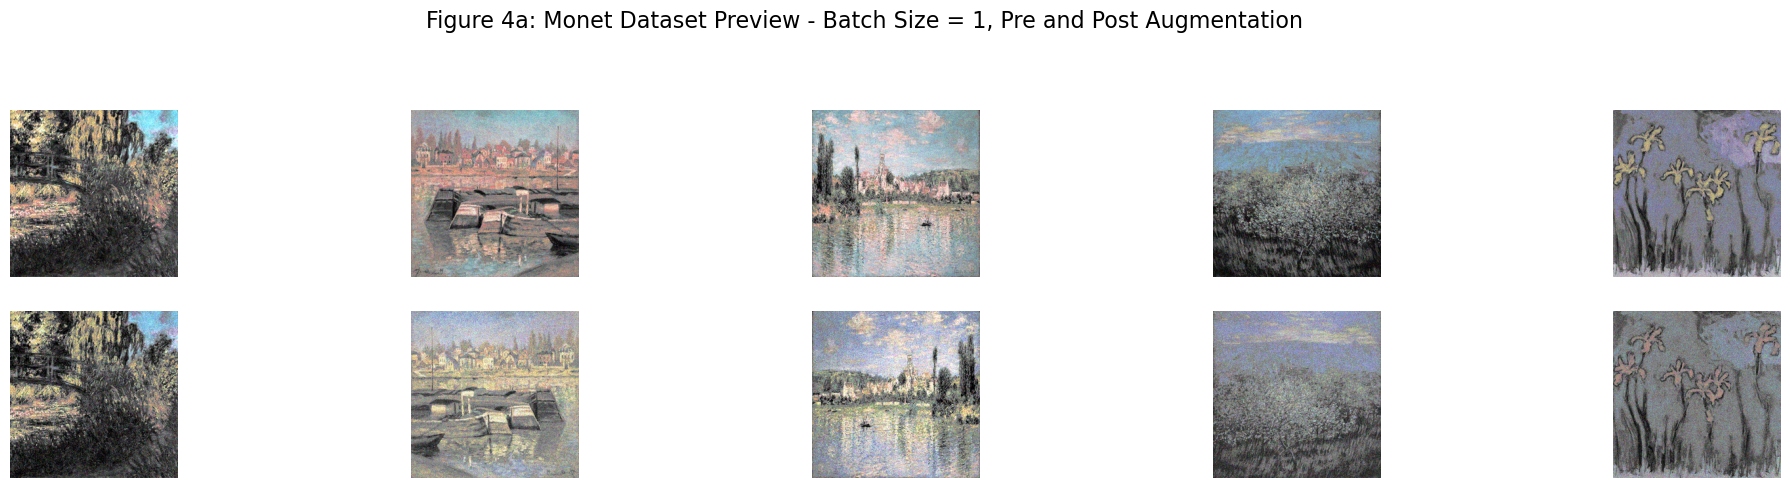

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.23702097..1.1293486].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.22918928..1.0328009].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.059436858..1.1678619].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11238712..1.2223232].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11759633..0.9939788].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.094555676..1.035296].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0

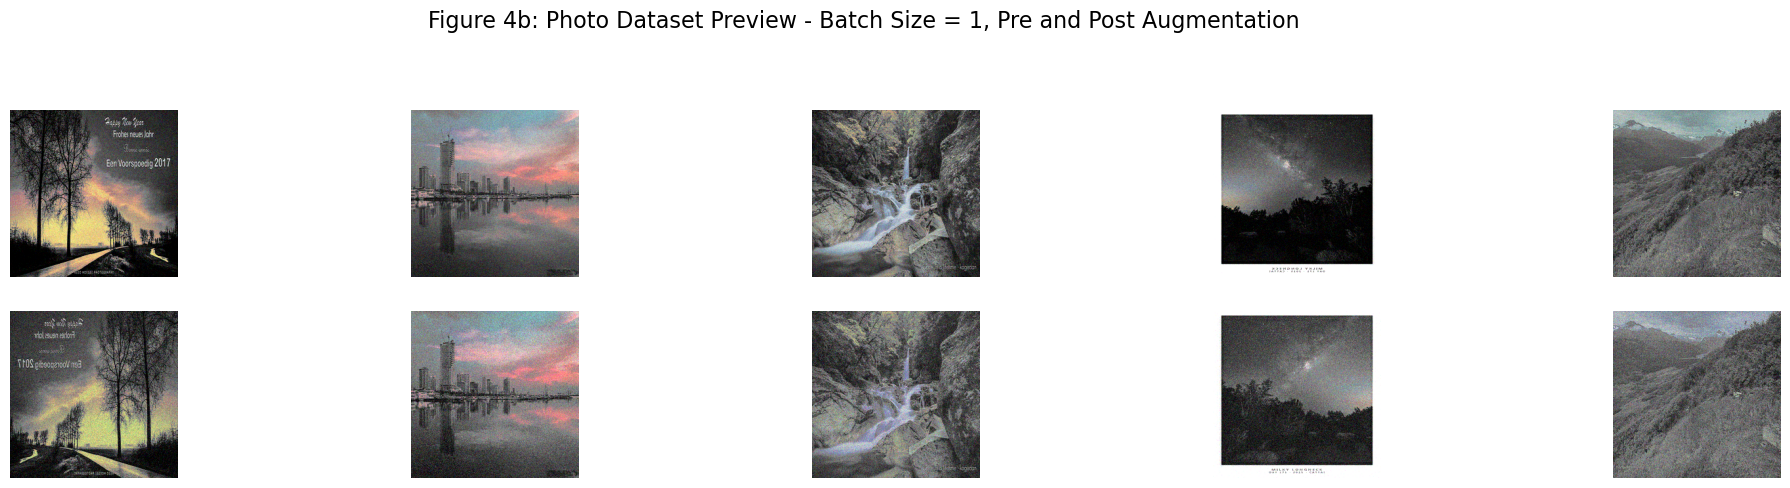

In [ ]:
# Function to show augmented and non-augmented images in four separate rows
def show_image_batchsize1_with_aug(dataset, title, n=5):
    plt.figure(figsize=(n * 5, 10))  # Adjusting the size to fit 4 rows of images

    for i, batch in enumerate(dataset.take(n)):
        original_image = batch[0]  # Since batch size is 1

        augmented_image = augment_image(original_image)

        original_image_display = (original_image + 1.0) / 2.0
        augmented_image_display = (augmented_image + 1.0) / 2.0

        plt.subplot(4, n, i + 1)
        plt.imshow(original_image_display)
        plt.axis('off')

        plt.subplot(4, n, i + 1 + n)
        plt.imshow(augmented_image_display)
        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.show()

show_image_batchsize1_with_aug(monet_train_batchsize1_with_aug, "Figure 4a: Monet Dataset Preview - Batch Size = 1, Pre and Post Augmentation", n=5)
show_image_batchsize1_with_aug(photo_train_batchsize1_with_aug, "Figure 4b: Photo Dataset Preview - Batch Size = 1, Pre and Post Augmentation", n=5)


# 3 Model Architecture

## 3.1 Downsampler and Upsampler Definition

In the architecture of the generator, downsampling and upsampling layers are used to progressively reduce and expand the spatial dimensions of the input images. The downsampler and upsampler are key components of the generator's encoder-decoder structure, where the downsampler reduces the spatial size while capturing higher-level features, and the upsampler increases the spatial resolution to generate the output image in the desired style.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, LeakyReLU, Conv2DTranspose, ReLU, Dropout, Add, Layer

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = Sequential()
    result.add(ReflectionPadding2D(padding=1))
    result.add(Conv2D(filters, size, strides=2, padding='valid',
                      kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        result.add(tf.keras.layers.LayerNormalization(epsilon=1e-5))  # fallback if no tfa
    result.add(LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.LayerNormalization(epsilon=1e-5))  # fallback for instance norm
    if apply_dropout:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result



## 3.2 Resnet Block

The Resnet Block is designed to improve training stability and model performance by introducing shortcut connections. It consists of two convolutional layers with ReLU activations, along with a separate 1×1 convolution to match the input and output dimensions when necessary. During the forward pass, the input is transformed through the two convolutional layers, and the original input (adjusted if needed) is added back to the output, forming a residual connection. This structure helps preserve information across layers and mitigates issues such as vanishing gradients during training.


In [ ]:
class ResnetBlock(Layer):
    def __init__(self, filters):
        super(ResnetBlock, self).__init__()
        self.conv1 = Conv2D(filters, kernel_size=3, padding="same")
        self.conv2 = Conv2D(filters, kernel_size=3, padding="same")
        self.relu = ReLU()

        # To match the input and output shapes in the residual connection
        self.matching_conv = Conv2D(filters, kernel_size=1, padding="same")

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.relu(x)
        x = self.conv2(x)

        # Match the dimensions of the input and output tensors
        inputs = self.matching_conv(inputs)

        return x + inputs

## 3.3 ReflectionPadding2D Layer

The ReflectionPadding2D layer adds reflective padding to the input tensor along the height and width dimensions. This type of padding is beneficial for convolutional neural networks, especially in cases where boundary artifacts can be problematic. By reflecting the pixel values at the edges, it reduces the likelihood of introducing unnatural transitions at the borders of the image. The layer is initialized with padding values for the height and width, and the `call` method applies the padding using TensorFlow's `tf.pad` function with the 'REFLECT' mode.

In [ ]:
class ReflectionPadding2D(Layer):
    def __init__(self, filters):
        super(ReflectionPadding2D, self).__init__()
        self.filters = filters

    def build(self, input_shape):
        self.padding = [[0, 0], [1, 1], [1, 1], [0, 0]]  # Padding for height and width

    def call(self, input_tensor, **kwargs):
        return tf.pad(input_tensor, self.padding, mode='REFLECT')

## 3.3 Generator

The BaseGenerator class defines the architecture of a deep convolutional neural network for generating images. It follows an encoder-decoder structure, where the downsampling layers progressively reduce the spatial dimensions of the input image while capturing high-level features. After downsampling, two residual blocks refine these features. The upsampling layers then restore the image resolution to the original size, producing the final output in the desired style.

The model consists of:

- Downsampling Layers: Convolutional layers that progressively reduce the image size and extract essential features.

- Residual Blocks: These blocks apply convolutions with skip connections to help preserve information across layers.

- Upsampling Layers: Transposed convolution layers increase the spatial resolution, ensuring that the output image matches the original size (256x256).

The final output of the generator is a 256x256 RGB image.

In [ ]:
class BaseGenerator(tf.keras.Model):
    def __init__(self, filters=64):
        super(BaseGenerator, self).__init__()

        # Downsampling layers
        self.downsample1 = Conv2D(filters, kernel_size=4, strides=2, padding='same')  # (1, 128, 128, filters)
        self.downsample2 = Conv2D(filters * 2, kernel_size=4, strides=2, padding='same')  # (1, 64, 64, filters*2)
        self.downsample3 = Conv2D(filters * 4, kernel_size=4, strides=2, padding='same')  # (1, 32, 32, filters*4)

        # Residual blocks
        self.resnet_block1 = ResnetBlock(filters * 4)
        self.resnet_block2 = ResnetBlock(filters * 4)

        # Upsampling layers to return to the input size (256x256)
        self.upsample1 = Conv2DTranspose(filters * 2, kernel_size=4, strides=2, padding='same', activation='relu')  # (1, 64, 64, filters*2)
        self.upsample2 = Conv2DTranspose(filters, kernel_size=4, strides=2, padding='same', activation='relu')  # (1, 128, 128, filters)
        self.upsample3 = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')  # Final output layer (1, 256, 256, 3)

    def call(self, input_tensor, training=False, **kwargs):
        # Downsampling pass
        x = self.downsample1(input_tensor)  # (1, 128, 128, filters)
        x = self.downsample2(x)  # (1, 64, 64, filters*2)
        x = self.downsample3(x)  # (1, 32, 32, filters*4)

        # Residual blocks
        x = self.resnet_block1(x)  # (1, 32, 32, filters*4)
        x = self.resnet_block2(x)  # (1, 32, 32, filters*4)

        # Upsampling pass with the correct strides to match the original size
        x = self.upsample1(x)  # (1, 64, 64, filters*2)
        x = self.upsample2(x)  # (1, 128, 128, filters)
        x = self.upsample3(x)  # Final output (1, 256, 256, 3)

        return x

# Instantiate the generator
gen = BaseGenerator(filters=64)

# Test the generator with a dummy input
dummy_input = tf.random.normal([1, 256, 256, 3])  # One 256x256 RGB image
gen_output = gen(dummy_input)

# Check the output shape
print("Generator output:", gen_output.shape)  # Should be (1, 256, 256, 3)

gen = BaseGenerator(filters=64)
dummy_input = tf.random.normal([1, 256, 256, 3])
_ = gen(dummy_input)
gen.summary()


Generator output: (1, 256, 256, 3)


Model: "base_generator_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (1, 128, 128, 64)      │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (1, 64, 64, 128)       │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (1, 32, 32, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_4 (ResnetBlock)    │ ?                      │     1,245,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_block_5 (ResnetBlock)    │ ?                      │     1,245,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (1, 64, 64, 128)       │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (1, 128, 128, 64)      │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (1, 256, 256, 3)       │         3,075 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,809,411 (14.53 MB)

 Trainable params: 3,809,411 (14.53 MB)

 Non-trainable params: 0 (0.00 B)

## 3.4 Discriminator

The Discriminator class is a convolutional neural network (CNN) model designed to distinguish between real and generated images. It follows a patch-based architecture, progressively downsampling the input image through multiple convolutional layers to extract relevant features. The model applies LeakyReLU activations after each convolution to introduce non-linearity, and incorporates Batch Normalization and Dropout to stabilize training and prevent overfitting.

The network architecture includes:

- Convolutional Layers: These layers perform downsampling, reducing the spatial resolution while increasing the number of feature maps to capture high-level representations.

- LeakyReLU Activations: Non-linear activations are used to allow small negative gradients, aiding the model in learning more efficiently.

- Batch Normalization: Applied after each convolution to normalize activations, helping with model convergence.

- Dropout: Regularization technique used to prevent overfitting by randomly dropping units during training.

- Final Convolution Layer: Outputs a single value per image, indicating whether the image is real (close to 1) or fake (close to 0).

- The output of the discriminator is a probability map (1, 16, 16, 1) indicating the authenticity of the image.

In [ ]:
class Discriminator(tf.keras.Model):
    def __init__(self, input_shape=(256, 256, 3)):
        super(Discriminator, self).__init__()

        initializer = tf.random_normal_initializer(0., 0.02)

        self.conv1 = layers.Conv2D(64, kernel_size=4, strides=2, padding='same',
                                   kernel_initializer=initializer)
        self.lrelu1 = layers.LeakyReLU(0.2)

        self.conv2 = layers.Conv2D(128, kernel_size=4, strides=2, padding='same',
                                   kernel_initializer=initializer)
        self.bn2 = layers.BatchNormalization()
        self.lrelu2 = layers.LeakyReLU(0.2)
        self.drop2 = layers.Dropout(0.3)

        self.conv3 = layers.Conv2D(256, kernel_size=4, strides=2, padding='same',
                                   kernel_initializer=initializer)
        self.bn3 = layers.BatchNormalization()
        self.lrelu3 = layers.LeakyReLU(0.2)
        self.drop3 = layers.Dropout(0.3)

        self.conv4 = layers.Conv2D(512, kernel_size=4, strides=2, padding='same',
                                   kernel_initializer=initializer)
        self.bn4 = layers.BatchNormalization()
        self.lrelu4 = layers.LeakyReLU(0.2)
        self.drop4 = layers.Dropout(0.3)

        self.final_conv = layers.Conv2D(1, kernel_size=4, strides=1, padding='same',
                                        kernel_initializer=initializer)
        self.output_activation = layers.Activation('sigmoid')

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.lrelu1(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.lrelu2(x)
        x = self.drop2(x, training=training)

        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = self.lrelu3(x)
        x = self.drop3(x, training=training)

        x = self.conv4(x)
        x = self.bn4(x, training=training)
        x = self.lrelu4(x)
        x = self.drop4(x, training=training)

        x = self.final_conv(x)
        return self.output_activation(x)

disc = Discriminator()
dummy_input = tf.random.normal([1, 256, 256, 3])
output = disc(dummy_input)
print(output.shape)  # Should be (1, 16, 16, 1) for 256x256 input

disc.summary()

(1, 16, 16, 1)


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (1, 128, 128, 64)      │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (1, 64, 64, 128)       │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (1, 64, 64, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (1, 32, 32, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (1, 32, 32, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (1, 16, 16, 512)       │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (1, 16, 16, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (1, 16, 16, 1)         │         8,193 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,768,321 (10.56 MB)

 Trainable params: 2,766,529 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

## 3.5 Loss Functions

This section defines various loss functions used for training the Generative Adversarial Network (GAN) and its components (Discriminator and Generator). The functions include:

1. **Discriminator Loss** (`discriminator_loss`):
   - This loss function computes the binary cross-entropy between the discriminator’s output for real and fake images. The real images are labeled as ones, and the fake images as zeros. The total loss is the sum of both real and fake losses.

2. **Generator Loss** (`generator_loss`):
   - This loss measures the binary cross-entropy between the discriminator’s output for fake images and the target label (ones). The generator aims to maximize this loss to fool the discriminator into classifying its generated images as real.

3. **Cycle Consistency Loss** (`cycle_consistency_loss`):
   - This function calculates the L1 (absolute difference) loss between a real image and its reconstructed version after being cycled through the generator. It encourages the generator to produce images that are close to the original input when reconstructed.

4. **Identity Loss** (`identity_loss`):
   - Similar to the cycle consistency loss, this function calculates the L1 loss between a real image and its generated counterpart, ensuring that the generator preserves the identity of the input images.

5. **Total Generator Loss with Identity** (`total_generator_loss_with_identity`):
   - This function computes the total generator loss by combining adversarial loss, cycle consistency loss, and identity loss. The adversarial loss encourages the generator to produce realistic images, the cycle consistency loss ensures input images can be reconstructed, and the identity loss maintains input identity. Weights for cycle consistency and identity loss can be adjusted.


In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

def cycle_consistency_loss(real_image, reconstructed_image):
    """
    Computes the cycle consistency loss (L1 loss) between real and reconstructed images.
    """
    return tf.reduce_mean(tf.abs(real_image - reconstructed_image))

def identity_loss(real_image, generated_image):
    """
    Computes the identity loss (L1 loss) between the real image and the generated image.
    """
    return tf.reduce_mean(tf.abs(real_image - generated_image))

def total_generator_loss_with_identity(real_image_A, fake_image_B, reconstructed_A,
                                        real_image_B, fake_image_A, reconstructed_B,
                                        cycle_weight=10.0, identity_weight=5.0):
    """
    Computes the total generator loss, which includes adversarial loss, cycle consistency loss, and identity loss.
    """
    # Adversarial loss for the generator (trying to fool the discriminator)
    g_loss_AB = generator_loss(fake_image_B)  # Adversarial loss for A->B generator
    g_loss_BA = generator_loss(fake_image_A)  # Adversarial loss for B->A generator

    # Cycle consistency loss
    cycle_loss_AB = cycle_consistency_loss(real_image_A, reconstructed_A)
    cycle_loss_BA = cycle_consistency_loss(real_image_B, reconstructed_B)

    # Identity loss
    identity_loss_AB = identity_loss(real_image_A, fake_image_B)
    identity_loss_BA = identity_loss(real_image_B, fake_image_A)

    # Total generator loss: adversarial loss + cycle consistency loss + identity loss
    total_g_loss_AB = g_loss_AB + cycle_weight * cycle_loss_AB + identity_weight * identity_loss_AB
    total_g_loss_BA = g_loss_BA + cycle_weight * cycle_loss_BA + identity_weight * identity_loss_BA

    # Return the total generator loss for both generators
    return total_g_loss_AB, total_g_loss_BA


# 4 Model Training

This section defines two training functions, `train_batchsize1_epochs50_lr0002` and `train_batchsize8_epochs50_lr0002`, which are designed to train the Generative Adversarial Network (GAN) with different batch sizes, using the specified learning rate, cycle consistency loss, and identity loss.

### `train_batchsize1_epochs50_lr0002`
- **Purpose**: Trains the GAN model with a batch size of 1 for 50 epochs using a learning rate of 0.0002. It includes options for augmented or non-augmented datasets.
- **Steps**:
  1. **Data Handling**: Uses `monet_train` and `photo_train` datasets, where `monet_train` represents the target images, and `photo_train` represents the input images.
  2. **Optimizers**: Both the generator and discriminator use Adam optimizers with specified learning rates and beta values.
  3. **Loss Calculation**: The generator and discriminator losses are computed for each training step, including adversarial loss, cycle consistency loss, and identity loss for the generator. The discriminator evaluates both real and fake images.
  4. **Gradient Updates**: The gradients are computed and applied to both the discriminator and generator to minimize the respective losses.
  5. **Checkpointing**: Generator weights are saved at the end of each epoch, and the loss metrics are logged into a CSV file for future analysis.

### `train_batchsize8_epochs50_lr0002`
- **Purpose**: Similar to the first function, but with a batch size of 8, this function trains the GAN model for 50 epochs using the same learning rate and loss functions. It can also handle augmented or non-augmented datasets.
- **Steps**: The process is similar to the previous function, but with a larger batch size. The weights are saved after each epoch, and the loss metrics are logged as well.

Both functions are customizable with the `cycle_weight` and `identity_weight` parameters to adjust the importance of cycle consistency and identity preservation in the loss functions. The models are saved after each epoch, and final weights are stored at the end of the training.


In [ ]:
def train_batchsize1_epochs50_lr0002(generator, discriminator, monet_train, photo_train, epochs=50, cycle_weight=10.0, identity_weight=5.0, is_augmented=False):

    if is_augmented:
        checkpoint_dir = './checkpoints_batchsize1_epochs50_lr0002_with_aug'
        losses_log_file = 'training_losses_batchsize1_with_aug.csv'
    else:
        checkpoint_dir = './checkpoints_batchsize1_epochs50_lr0002'
        losses_log_file = 'training_losses_batchsize1.csv'

    os.makedirs(checkpoint_dir, exist_ok=True)

    losses_log = []

    # Optimizers for generator and discriminator
    g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.99)
    d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.99)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        epoch_losses = {'epoch': epoch + 1}

        for real_images_A, real_images_B in zip(photo_train, monet_train):
            # Forward pass through the generator
            with tf.GradientTape(persistent=True) as tape:
                fake_images_B = generator(real_images_A, training=True)
                fake_images_A = generator(real_images_B, training=True)

                real_output_A = discriminator(real_images_A, training=True)
                fake_output_A = discriminator(fake_images_A, training=True)
                real_output_B = discriminator(real_images_B, training=True)
                fake_output_B = discriminator(fake_images_B, training=True)

                # Compute generator losses (with cycle and identity loss)
                g_loss_AB, g_loss_BA = total_generator_loss_with_identity(
                    real_images_A, fake_images_B, fake_images_A, real_images_B,
                    fake_images_A, fake_images_B, cycle_weight, identity_weight
                )

                d_loss_A = discriminator_loss(real_output_A, fake_output_A)
                d_loss_B = discriminator_loss(real_output_B, fake_output_B)

            # Apply gradients for discriminator
            grads_d_A = tape.gradient(d_loss_A, discriminator.trainable_variables)
            grads_d_B = tape.gradient(d_loss_B, discriminator.trainable_variables)
            d_optimizer.apply_gradients(zip(grads_d_A, discriminator.trainable_variables))
            d_optimizer.apply_gradients(zip(grads_d_B, discriminator.trainable_variables))

            # Apply gradients for generator
            grads_g_AB = tape.gradient(g_loss_AB, generator.trainable_variables)
            grads_g_BA = tape.gradient(g_loss_BA, generator.trainable_variables)
            g_optimizer.apply_gradients(zip(grads_g_AB, generator.trainable_variables))
            g_optimizer.apply_gradients(zip(grads_g_BA, generator.trainable_variables))

        # Save loss metrics for each epoch
        epoch_losses['Generator Loss A->B'] = g_loss_AB.numpy()
        epoch_losses['Generator Loss B->A'] = g_loss_BA.numpy()
        epoch_losses['Discriminator Loss A'] = d_loss_A.numpy()
        epoch_losses['Discriminator Loss B'] = d_loss_B.numpy()
        losses_log.append(epoch_losses)

        # Save generator weights after each epoch
        generator.save_weights(os.path.join(checkpoint_dir, f'epoch_{epoch+1}_batchsize1.weights.h5'))

        # Print the loss summary for the current epoch
        print(f"Epoch {epoch + 1}/{epochs} | "
              f"Gen A->B: {g_loss_AB:.4f} | Gen B->A: {g_loss_BA:.4f} | "
              f"Disc A: {d_loss_A:.4f} | Disc B: {d_loss_B:.4f}")

    # Save the entire log of losses to CSV
    df_losses = pd.DataFrame(losses_log)
    df_losses.to_csv(losses_log_file, index=False)

    # Save the full generator model after training finishes
    if is_augmented:
        generator.save('gen_batchsize1_with_aug.h5')
    else:
        generator.save('gen_batchsize1.h5')


# Instantiate your models
gen_batchsize1 = BaseGenerator(filters=64)
disc_batchsize1 = Discriminator()

gen_batchsize1_with_aug = BaseGenerator(filters=64)
disc_batchsize1_with_aug = Discriminator()


# Example usage for the original dataset (non-augmented)
train_batchsize1_epochs50_lr0002(gen_batchsize1, disc_batchsize1, monet_train_batchsize1, photo_train_batchsize1, epochs=50, is_augmented=False)

# Example usage for the augmented dataset
train_batchsize1_epochs50_lr0002(gen_batchsize1_with_aug, disc_batchsize1_with_aug, monet_train_batchsize1_with_aug, photo_train_batchsize1_with_aug, epochs=50, is_augmented=True)



Epoch 1/50


/Users/lillianbrown/miniforge3/envs/tf-m1/lib/python3.9/site-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/50 | Gen A->B: 7.8724 | Gen B->A: 7.2456 | Disc A: 0.0036 | Disc B: 0.0053

Epoch 2/50
Epoch 2/50 | Gen A->B: 6.1934 | Gen B->A: 6.3756 | Disc A: 0.0017 | Disc B: 0.0014

Epoch 3/50
Epoch 3/50 | Gen A->B: 6.1028 | Gen B->A: 4.8861 | Disc A: 0.0010 | Disc B: 0.0048

Epoch 4/50
Epoch 4/50 | Gen A->B: 6.7496 | Gen B->A: 5.5731 | Disc A: 0.0013 | Disc B: 0.0190

Epoch 5/50
Epoch 5/50 | Gen A->B: 8.1660 | Gen B->A: 7.5858 | Disc A: 0.0004 | Disc B: 0.0034

Epoch 6/50
Epoch 6/50 | Gen A->B: 4.6414 | Gen B->A: 5.2156 | Disc A: 0.0149 | Disc B: 0.0038

Epoch 7/50
Epoch 7/50 | Gen A->B: 5.4248 | Gen B->A: 4.0196 | Disc A: 0.0010 | Disc B: 0.0005

Epoch 8/50
Epoch 8/50 | Gen A->B: 6.2261 | Gen B->A: 6.6746 | Disc A: 0.0009 | Disc B: 0.0027

Epoch 9/50
Epoch 9/50 | Gen A->B: 7.9954 | Gen B->A: 6.6717 | Disc A: 0.0006 | Disc B: 0.0004

Epoch 10/50
Epoch 10/50 | Gen A->B: 5.0522 | Gen B->A: 5.6579 | Disc A: 0.0005 | Disc B: 0.0012

Epoch 11/50
Epoch 11/50 | Gen A->B: 7.2986 | Gen B->A: 6.25

Epoch 50/50 | Gen A->B: 7.3578 | Gen B->A: 4.8141 | Disc A: 0.0004 | Disc B: 0.0000

Epoch 1/50
Epoch 1/50 | Gen A->B: 5.3537 | Gen B->A: 7.7227 | Disc A: 0.0507 | Disc B: 0.0152

Epoch 2/50
Epoch 2/50 | Gen A->B: 5.6803 | Gen B->A: 5.1002 | Disc A: 0.0016 | Disc B: 0.0015

Epoch 3/50
Epoch 3/50 | Gen A->B: 4.7131 | Gen B->A: 4.9159 | Disc A: 0.0054 | Disc B: 0.0021

Epoch 4/50
Epoch 4/50 | Gen A->B: 3.9857 | Gen B->A: 6.1520 | Disc A: 0.0005 | Disc B: 0.0003

Epoch 5/50
Epoch 5/50 | Gen A->B: 4.8418 | Gen B->A: 4.3799 | Disc A: 0.0025 | Disc B: 0.0008

Epoch 6/50
Epoch 6/50 | Gen A->B: 4.3006 | Gen B->A: 3.7181 | Disc A: 0.0010 | Disc B: 0.0004

Epoch 7/50
Epoch 7/50 | Gen A->B: 5.7346 | Gen B->A: 3.6274 | Disc A: 0.0002 | Disc B: 0.0042

Epoch 8/50
Epoch 8/50 | Gen A->B: 5.8671 | Gen B->A: 4.9765 | Disc A: 0.0002 | Disc B: 0.0016

Epoch 9/50
Epoch 9/50 | Gen A->B: 7.5697 | Gen B->A: 7.3360 | Disc A: 0.0006 | Disc B: 0.0012

Epoch 10/50
Epoch 10/50 | Gen A->B: 9.4391 | Gen B->A: 4.160

2025-04-28 16:15:57.208802: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 14/50 | Gen A->B: 6.2944 | Gen B->A: 3.6579 | Disc A: 0.0000 | Disc B: 0.0001

Epoch 15/50
Epoch 15/50 | Gen A->B: 4.4318 | Gen B->A: 5.5098 | Disc A: 0.0000 | Disc B: 0.0000

Epoch 16/50
Epoch 16/50 | Gen A->B: 6.5028 | Gen B->A: 4.8228 | Disc A: 0.0000 | Disc B: 0.0000

Epoch 17/50
Epoch 17/50 | Gen A->B: 7.2519 | Gen B->A: 5.8268 | Disc A: 0.0000 | Disc B: 0.0000

Epoch 18/50
Epoch 18/50 | Gen A->B: 6.7216 | Gen B->A: 4.9118 | Disc A: 0.0000 | Disc B: 0.0000

Epoch 19/50
Epoch 19/50 | Gen A->B: 4.5851 | Gen B->A: 3.9466 | Disc A: 0.0000 | Disc B: 0.0000

Epoch 20/50
Epoch 20/50 | Gen A->B: 3.9663 | Gen B->A: 3.7540 | Disc A: 0.0000 | Disc B: 0.0000

Epoch 21/50
Epoch 21/50 | Gen A->B: 6.8773 | Gen B->A: 5.2085 | Disc A: 0.0000 | Disc B: 0.0001

Epoch 22/50
Epoch 22/50 | Gen A->B: 4.1151 | Gen B->A: 5.1496 | Disc A: 0.0000 | Disc B: 0.0000

Epoch 23/50
Epoch 23/50 | Gen A->B: 7.6253 | Gen B->A: 4.3799 | Disc A: 0.0000 | Disc B: 0.0000

Epoch 24/50
Epoch 24/50 | Gen A->B: 7.0728

Epoch 50/50 | Gen A->B: 3.8173 | Gen B->A: 4.2041 | Disc A: 0.0000 | Disc B: 0.0000


In [ ]:
def train_batchsize8_epochs50_lr0002(generator, discriminator, monet_train, photo_train, epochs=50, cycle_weight=10.0, identity_weight=5.0, is_augmented=False):

    # Directories and logging
    if is_augmented:
        checkpoint_dir = './checkpoints_batchsize8_epochs50_lr0002_with_aug'
        losses_log_file = 'training_losses_batchsize8_with_aug.csv'
    else:
        checkpoint_dir = './checkpoints_batchsize8_epochs50_lr0002'
        losses_log_file = 'training_losses_batchsize8.csv'

    os.makedirs(checkpoint_dir, exist_ok=True)
    losses_log = []

    # Optimizers
    g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.99)
    d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.99)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        epoch_losses = {'epoch': epoch + 1}

        for real_images_A, real_images_B in zip(photo_train, monet_train):
            with tf.GradientTape(persistent=True) as tape:
                # Generate fake images
                fake_images_B = generator(real_images_A, training=True)
                fake_images_A = generator(real_images_B, training=True)

                # Discriminator outputs
                real_output_A = discriminator(real_images_A, training=True)
                fake_output_A = discriminator(fake_images_A, training=True)
                real_output_B = discriminator(real_images_B, training=True)
                fake_output_B = discriminator(fake_images_B, training=True)

                # Generator losses
                g_loss_AB, g_loss_BA = total_generator_loss_with_identity(
                    real_images_A, fake_images_B, fake_images_A, real_images_B,
                    fake_images_A, fake_images_B, cycle_weight, identity_weight
                )

                # Discriminator losses
                d_loss_A = discriminator_loss(real_output_A, fake_output_A)
                d_loss_B = discriminator_loss(real_output_B, fake_output_B)

            # Apply discriminator gradients
            d_vars = discriminator.trainable_variables
            grads_d_A = tape.gradient(d_loss_A, d_vars)
            grads_d_B = tape.gradient(d_loss_B, d_vars)
            d_optimizer.apply_gradients(zip(grads_d_A, d_vars))
            d_optimizer.apply_gradients(zip(grads_d_B, d_vars))

            # Apply generator gradients
            g_vars = generator.trainable_variables
            grads_g_AB = tape.gradient(g_loss_AB, g_vars)
            grads_g_BA = tape.gradient(g_loss_BA, g_vars)
            g_optimizer.apply_gradients(zip(grads_g_AB, g_vars))
            g_optimizer.apply_gradients(zip(grads_g_BA, g_vars))

        # Log losses
        epoch_losses['Generator Loss A->B'] = g_loss_AB.numpy()
        epoch_losses['Generator Loss B->A'] = g_loss_BA.numpy()
        epoch_losses['Discriminator Loss A'] = d_loss_A.numpy()
        epoch_losses['Discriminator Loss B'] = d_loss_B.numpy()
        losses_log.append(epoch_losses)

        # Save generator weights
        generator.save_weights(os.path.join(checkpoint_dir, f'epoch_{epoch+1}_batchsize8.weights.h5'))

        print(f"Epoch {epoch + 1}/{epochs} | "
              f"Gen A->B: {g_loss_AB:.4f} | Gen B->A: {g_loss_BA:.4f} | "
              f"Disc A: {d_loss_A:.4f} | Disc B: {d_loss_B:.4f}")

    # Save all loss logs
    df_losses = pd.DataFrame(losses_log)
    df_losses.to_csv(losses_log_file, index=False)

    # Save the full generator model after training finishes
    if is_augmented:
        generator.save('gen_batchsize8_with_aug.h5')
    else:
        generator.save('gen_batchsize8.h5')

# Instantiate your models
gen_batchsize8 = BaseGenerator(filters=64)
disc_batchsize8 = Discriminator()

gen_batchsize8_with_aug = BaseGenerator(filters=64)
disc_batchsize8_with_aug = Discriminator()

# Train on original dataset (non-augmented)
train_batchsize8_epochs50_lr0002(gen_batchsize8, disc_batchsize8, monet_train_batchsize8, photo_train_batchsize8, epochs=50, is_augmented=False)

# Train on augmented dataset
train_batchsize8_epochs50_lr0002(gen_batchsize8_with_aug, disc_batchsize8_with_aug, monet_train_batchsize8_with_aug, photo_train_batchsize8_with_aug, epochs=50, is_augmented=True)



Epoch 1/50


/Users/lillianbrown/miniforge3/envs/tf-m1/lib/python3.9/site-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/50 | Gen A->B: 6.6410 | Gen B->A: 5.6278 | Disc A: 1.4844 | Disc B: 1.4337

Epoch 2/50
Epoch 2/50 | Gen A->B: 7.3510 | Gen B->A: 6.0504 | Disc A: 0.0518 | Disc B: 0.1232

Epoch 3/50
Epoch 3/50 | Gen A->B: 6.6965 | Gen B->A: 6.8910 | Disc A: 0.0183 | Disc B: 0.0171

Epoch 4/50
Epoch 4/50 | Gen A->B: 7.6683 | Gen B->A: 6.4018 | Disc A: 0.0055 | Disc B: 0.0085

Epoch 5/50
Epoch 5/50 | Gen A->B: 7.7901 | Gen B->A: 6.2593 | Disc A: 0.6691 | Disc B: 0.9748

Epoch 6/50
Epoch 6/50 | Gen A->B: 6.6053 | Gen B->A: 5.7818 | Disc A: 0.0109 | Disc B: 0.0212

Epoch 7/50
Epoch 7/50 | Gen A->B: 7.5174 | Gen B->A: 5.9198 | Disc A: 0.0077 | Disc B: 0.0189

Epoch 8/50
Epoch 8/50 | Gen A->B: 6.7548 | Gen B->A: 6.3218 | Disc A: 0.0048 | Disc B: 0.0130

Epoch 9/50
Epoch 9/50 | Gen A->B: 7.7649 | Gen B->A: 6.0256 | Disc A: 0.0057 | Disc B: 0.0070

Epoch 10/50
Epoch 10/50 | Gen A->B: 8.0599 | Gen B->A: 6.6679 | Disc A: 0.0081 | Disc B: 0.0037

Epoch 11/50
Epoch 11/50 | Gen A->B: 7.7065 | Gen B->A: 5.70

Epoch 50/50 | Gen A->B: 7.1354 | Gen B->A: 5.2850 | Disc A: 0.0015 | Disc B: 0.0162

Epoch 1/50
Epoch 1/50 | Gen A->B: 7.2793 | Gen B->A: 5.6822 | Disc A: 2.1918 | Disc B: 2.5084

Epoch 2/50
Epoch 2/50 | Gen A->B: 7.0757 | Gen B->A: 6.1213 | Disc A: 0.0794 | Disc B: 0.0970

Epoch 3/50
Epoch 3/50 | Gen A->B: 6.8728 | Gen B->A: 4.7665 | Disc A: 0.0208 | Disc B: 0.0400

Epoch 4/50
Epoch 4/50 | Gen A->B: 6.7211 | Gen B->A: 5.3874 | Disc A: 0.0121 | Disc B: 0.0174

Epoch 5/50
Epoch 5/50 | Gen A->B: 6.3588 | Gen B->A: 4.9134 | Disc A: 0.0066 | Disc B: 0.0137

Epoch 6/50
Epoch 6/50 | Gen A->B: 7.5131 | Gen B->A: 6.0338 | Disc A: 0.0038 | Disc B: 0.0419

Epoch 7/50
Epoch 7/50 | Gen A->B: 5.4391 | Gen B->A: 5.2280 | Disc A: 0.0876 | Disc B: 0.0828

Epoch 8/50
Epoch 8/50 | Gen A->B: 6.2893 | Gen B->A: 5.1723 | Disc A: 0.0227 | Disc B: 0.0536

Epoch 9/50
Epoch 9/50 | Gen A->B: 7.0263 | Gen B->A: 5.3755 | Disc A: 0.0073 | Disc B: 0.0132

Epoch 10/50
Epoch 10/50 | Gen A->B: 6.4944 | Gen B->A: 5.662

2025-04-28 23:12:07.909451: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 42/50 | Gen A->B: 5.9104 | Gen B->A: 5.1942 | Disc A: 0.0000 | Disc B: 0.0000

Epoch 43/50
Epoch 43/50 | Gen A->B: 6.7439 | Gen B->A: 5.8061 | Disc A: 0.0300 | Disc B: 0.1417

Epoch 44/50
Epoch 44/50 | Gen A->B: 8.3117 | Gen B->A: 5.8071 | Disc A: 0.0017 | Disc B: 0.0032

Epoch 45/50
Epoch 45/50 | Gen A->B: 7.4587 | Gen B->A: 6.3784 | Disc A: 0.0009 | Disc B: 0.0015

Epoch 46/50
Epoch 46/50 | Gen A->B: 8.0021 | Gen B->A: 5.6907 | Disc A: 0.0014 | Disc B: 0.0019

Epoch 47/50
Epoch 47/50 | Gen A->B: 6.9261 | Gen B->A: 6.2950 | Disc A: 0.0027 | Disc B: 0.0004

Epoch 48/50
Epoch 48/50 | Gen A->B: 5.7204 | Gen B->A: 6.1526 | Disc A: 0.0003 | Disc B: 0.0002

Epoch 49/50
Epoch 49/50 | Gen A->B: 6.4105 | Gen B->A: 5.4521 | Disc A: 0.0001 | Disc B: 0.0003

Epoch 50/50


Epoch 50/50 | Gen A->B: 7.0985 | Gen B->A: 5.8451 | Disc A: 0.0008 | Disc B: 0.0004


# 5 Model Tuning

The process of model tuning involved experimenting with various configurations to optimize the performance of the generator models. Specifically, two different batch sizes—1 and 8—were used to examine how the batch size influences the sharpness and quality of the Monet-style images generated by the model. Additionally, both non-augmented and augmented images were compared to assess how image augmentation affected the sharpness and overall quality of the output.

The results from these experiments showed a noticeable difference in sharpness between the two batch sizes. For both non-augmented and augmented images, batch size 1 consistently produced sharper images than batch size 8, which could indicate that smaller batch sizes allow for more precise updates during training, resulting in clearer images. Furthermore, augmentation led to a decrease in sharpness for both batch sizes, as expected, since augmentation introduces transformations that can blur or distort the images to improve generalization.

In summary, this tuning phase demonstrated that batch size and augmentation both significantly influence the output quality of the generator model. While batch size 1 provided sharper results, augmentation typically decreased sharpness but may offer benefits in terms of model generalization. Further optimization may be necessary to find the optimal balance between batch size, augmentation, and sharpness.


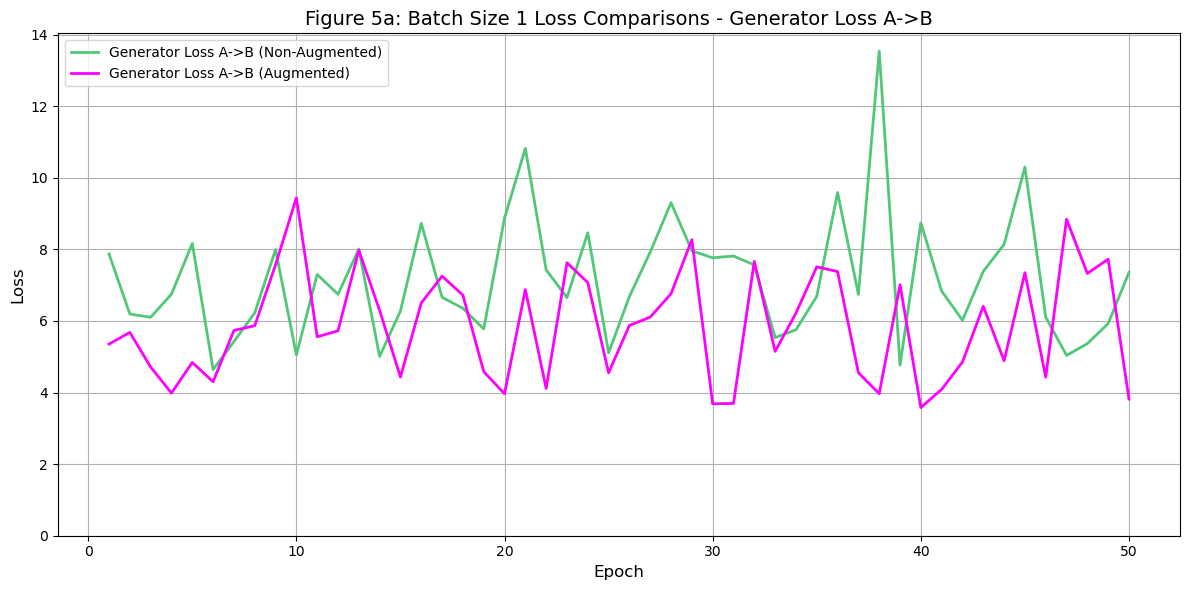

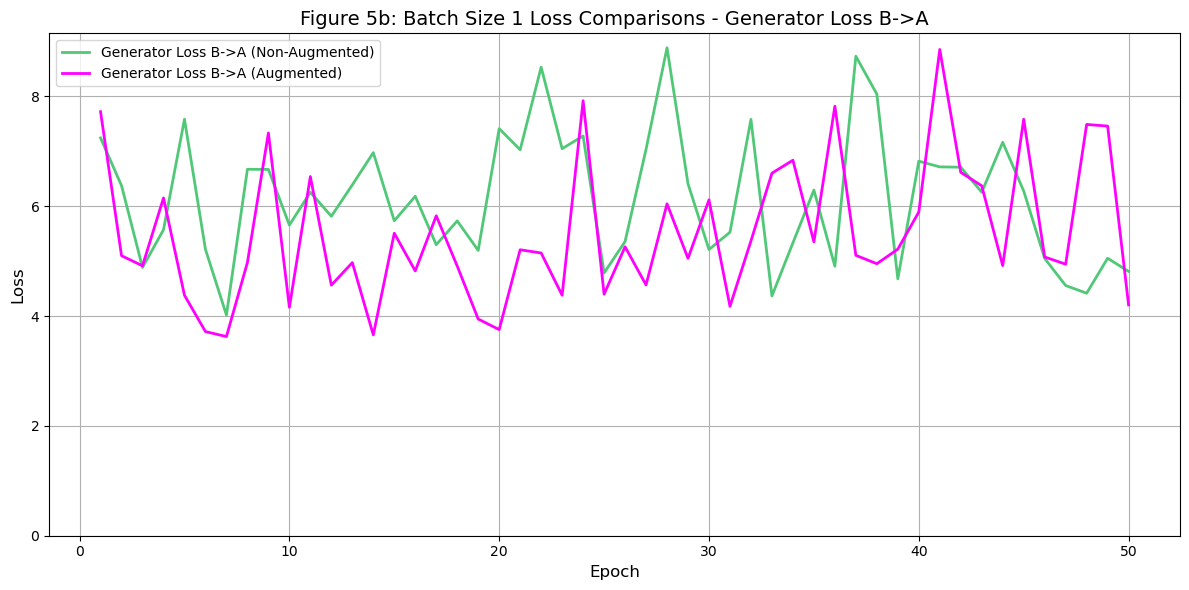

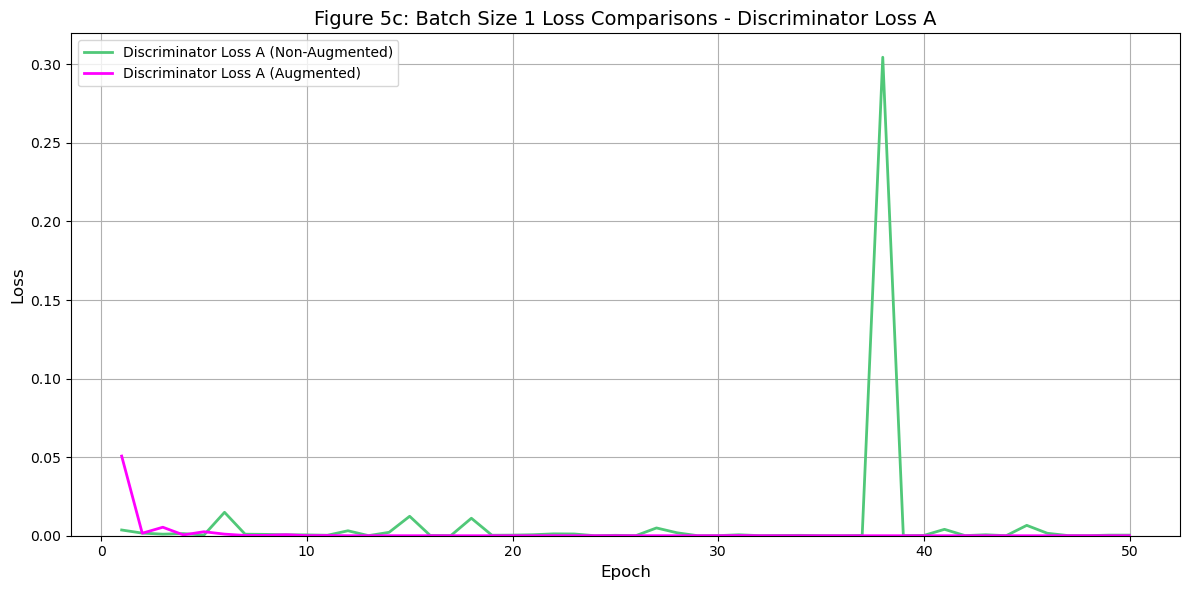

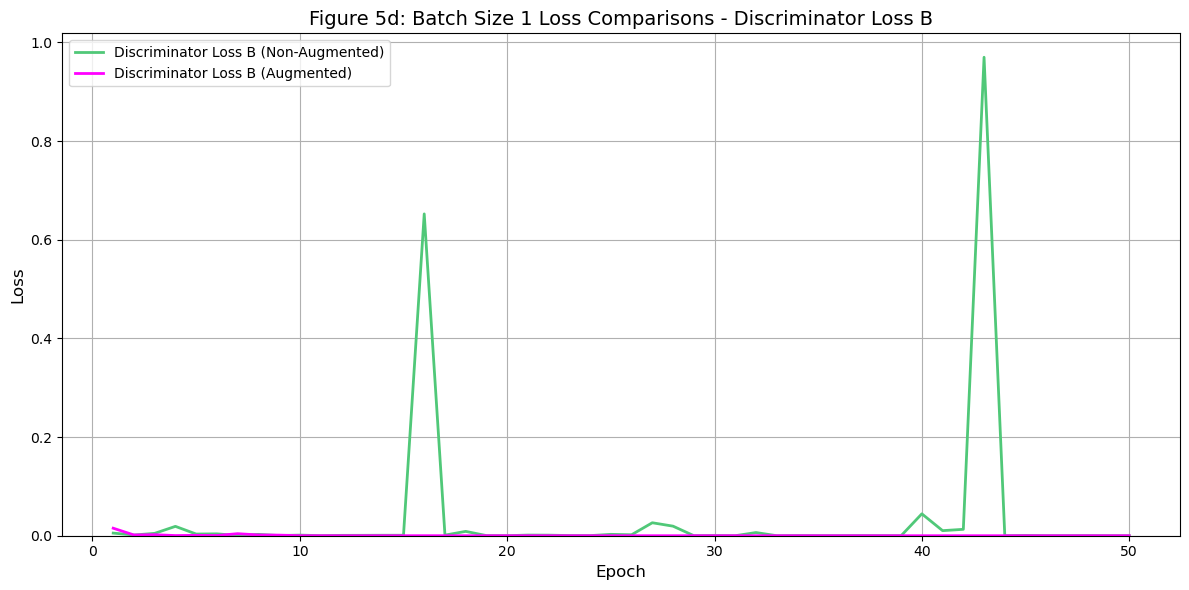

In [ ]:
df_losses_batchsize1 = pd.read_csv('training_losses_batchsize1.csv')
df_losses_batchsize1_with_aug = pd.read_csv('training_losses_batchsize1_with_aug.csv')

figsize = (12, 6)

# Plot Generator Loss A->B
plt.figure(figsize=figsize)
plt.plot(df_losses_batchsize1['epoch'], df_losses_batchsize1['Generator Loss A->B'], label='Generator Loss A->B (Non-Augmented)', color='#50C878', linestyle='-', linewidth=2)
plt.plot(df_losses_batchsize1_with_aug['epoch'], df_losses_batchsize1_with_aug['Generator Loss A->B'], label='Generator Loss A->B (Augmented)', color='magenta', linestyle='-', linewidth=2)
plt.title('Figure 5a: Batch Size 1 Loss Comparisons - Generator Loss A->B', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Generator Loss B->A
plt.figure(figsize=figsize)
plt.plot(df_losses_batchsize1['epoch'], df_losses_batchsize1['Generator Loss B->A'], label='Generator Loss B->A (Non-Augmented)', color='#50C878', linestyle='-', linewidth=2)
plt.plot(df_losses_batchsize1_with_aug['epoch'], df_losses_batchsize1_with_aug['Generator Loss B->A'], label='Generator Loss B->A (Augmented)', color='magenta', linestyle='-', linewidth=2)
plt.title('Figure 5b: Batch Size 1 Loss Comparisons - Generator Loss B->A', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Discriminator Loss A
plt.figure(figsize=figsize)
plt.plot(df_losses_batchsize1['epoch'], df_losses_batchsize1['Discriminator Loss A'], label='Discriminator Loss A (Non-Augmented)', color='#50C878', linestyle='-', linewidth=2)
plt.plot(df_losses_batchsize1_with_aug['epoch'], df_losses_batchsize1_with_aug['Discriminator Loss A'], label='Discriminator Loss A (Augmented)', color='magenta', linestyle='-', linewidth=2)
plt.title('Figure 5c: Batch Size 1 Loss Comparisons - Discriminator Loss A', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Discriminator Loss B
plt.figure(figsize=figsize)
plt.plot(df_losses_batchsize1['epoch'], df_losses_batchsize1['Discriminator Loss B'], label='Discriminator Loss B (Non-Augmented)', color='#50C878', linestyle='-', linewidth=2)
plt.plot(df_losses_batchsize1_with_aug['epoch'], df_losses_batchsize1_with_aug['Discriminator Loss B'], label='Discriminator Loss B (Augmented)', color='magenta', linestyle='-', linewidth=2)
plt.title('Figure 5d: Batch Size 1 Loss Comparisons - Discriminator Loss B', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


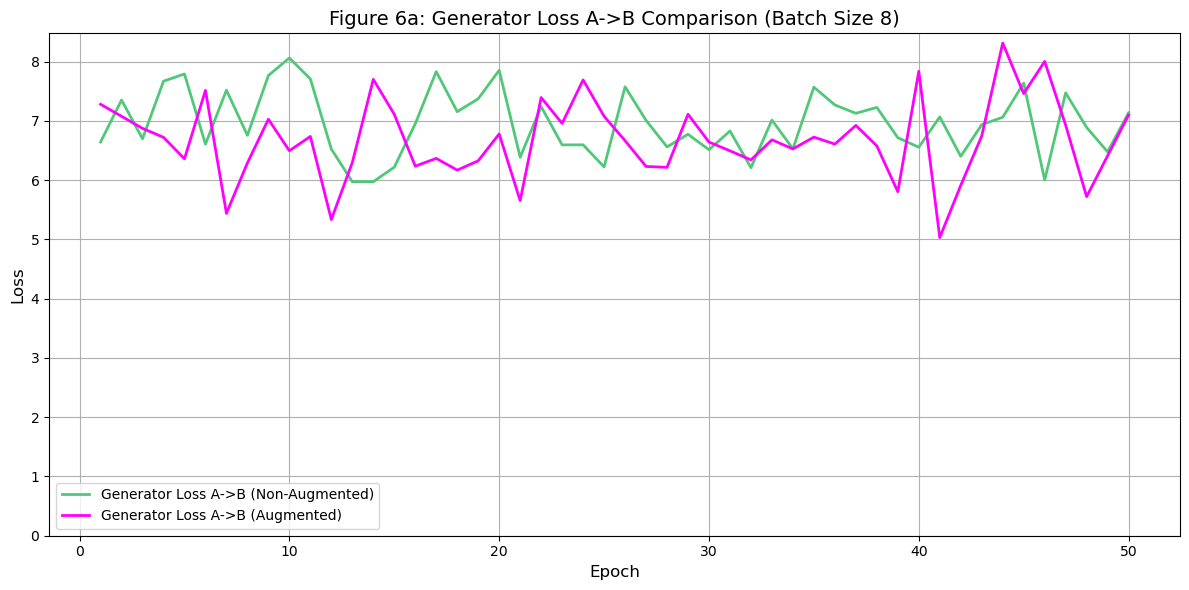

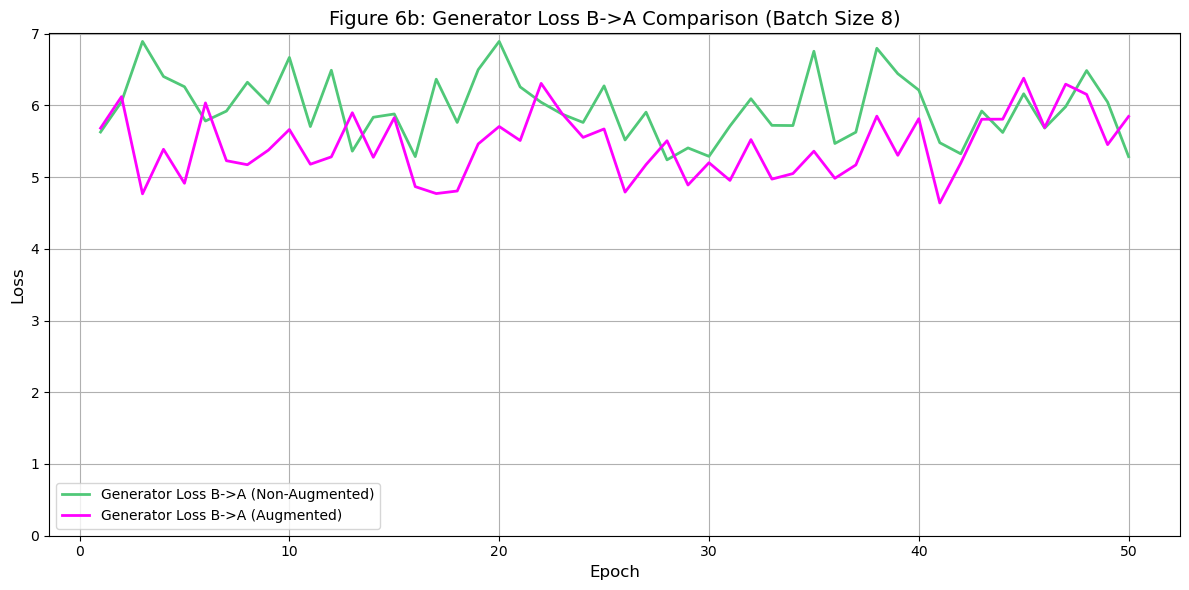

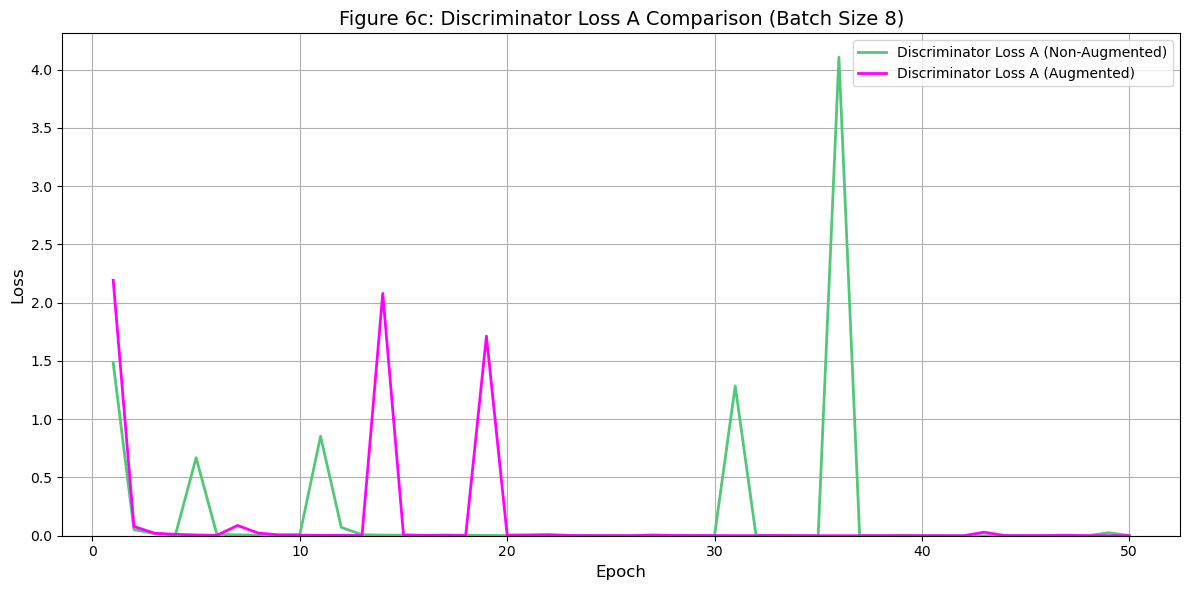

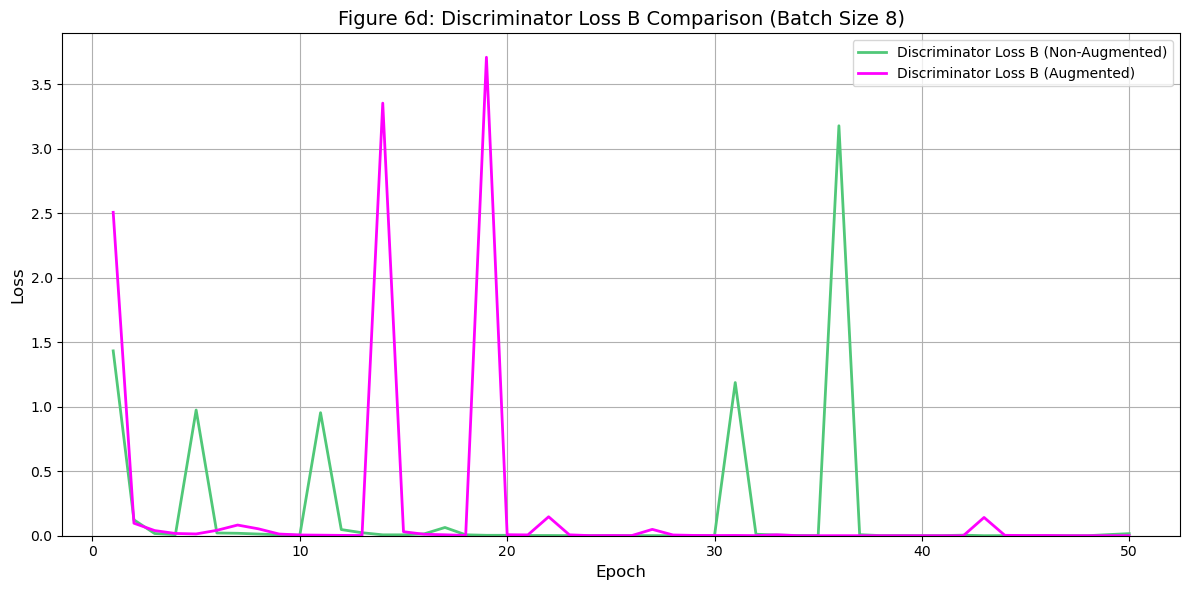

In [ ]:
df_losses_batchsize8 = pd.read_csv('training_losses_batchsize8.csv')
df_losses_batchsize8_with_aug = pd.read_csv('training_losses_batchsize8_with_aug.csv')

figsize = (12, 6)

# Plot Generator Loss A->B
plt.figure(figsize=figsize)
plt.plot(df_losses_batchsize8['epoch'], df_losses_batchsize8['Generator Loss A->B'], label='Generator Loss A->B (Non-Augmented)', color='#50C878', linestyle='-', linewidth=2)
plt.plot(df_losses_batchsize8_with_aug['epoch'], df_losses_batchsize8_with_aug['Generator Loss A->B'], label='Generator Loss A->B (Augmented)', color='magenta', linestyle='-', linewidth=2)
plt.title('Figure 6a: Generator Loss A->B Comparison (Batch Size 8)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.ylim(bottom=0)  # Y-axis starts at 0
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Generator Loss B->A
plt.figure(figsize=figsize)
plt.plot(df_losses_batchsize8['epoch'], df_losses_batchsize8['Generator Loss B->A'], label='Generator Loss B->A (Non-Augmented)', color='#50C878', linestyle='-', linewidth=2)
plt.plot(df_losses_batchsize8_with_aug['epoch'], df_losses_batchsize8_with_aug['Generator Loss B->A'], label='Generator Loss B->A (Augmented)', color='magenta', linestyle='-', linewidth=2)
plt.title('Figure 6b: Generator Loss B->A Comparison (Batch Size 8)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Discriminator Loss A
plt.figure(figsize=figsize)
plt.plot(df_losses_batchsize8['epoch'], df_losses_batchsize8['Discriminator Loss A'], label='Discriminator Loss A (Non-Augmented)', color='#50C878', linestyle='-', linewidth=2)
plt.plot(df_losses_batchsize8_with_aug['epoch'], df_losses_batchsize8_with_aug['Discriminator Loss A'], label='Discriminator Loss A (Augmented)', color='magenta', linestyle='-', linewidth=2)
plt.title('Figure 6c: Discriminator Loss A Comparison (Batch Size 8)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Discriminator Loss B
plt.figure(figsize=figsize)
plt.plot(df_losses_batchsize8['epoch'], df_losses_batchsize8['Discriminator Loss B'], label='Discriminator Loss B (Non-Augmented)', color='#50C878', linestyle='-', linewidth=2)
plt.plot(df_losses_batchsize8_with_aug['epoch'], df_losses_batchsize8_with_aug['Discriminator Loss B'], label='Discriminator Loss B (Augmented)', color='magenta', linestyle='-', linewidth=2)
plt.title('Figure 6d: Discriminator Loss B Comparison (Batch Size 8)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


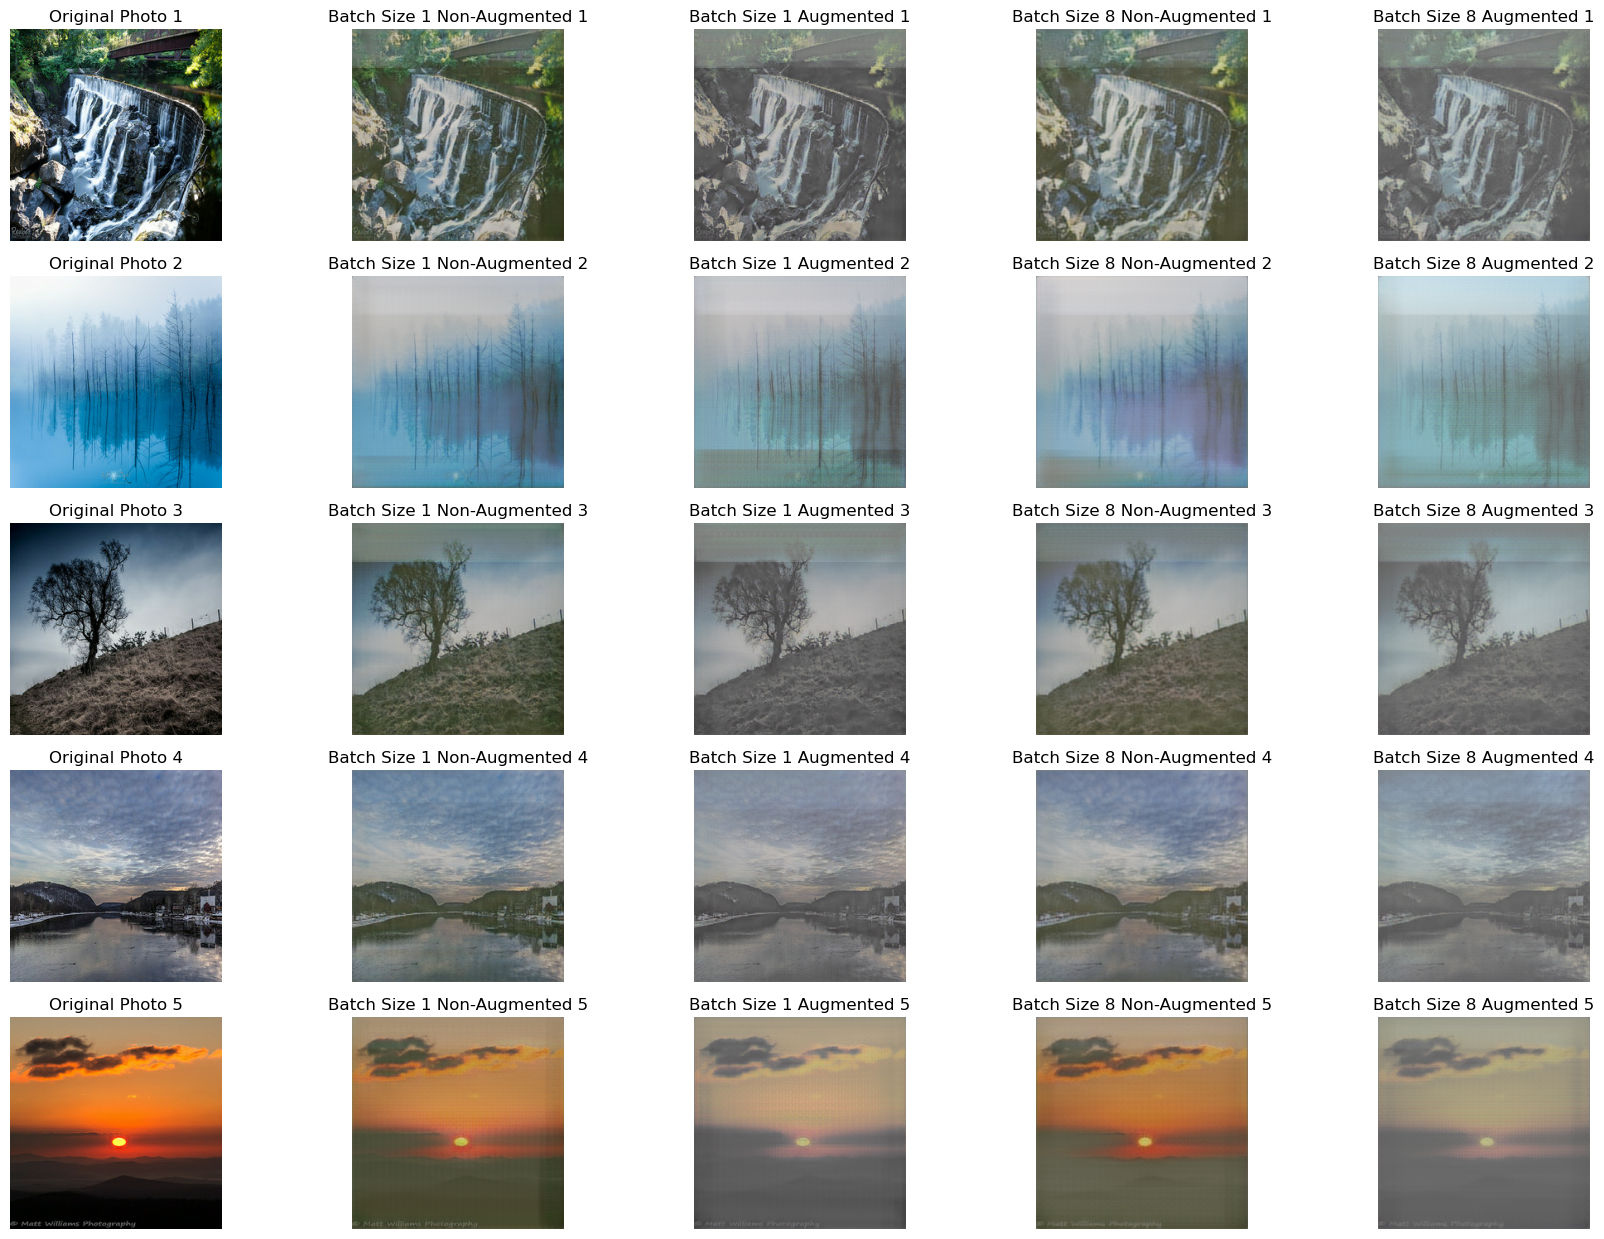

In [ ]:
def display_photo_to_monet_comparison(generator_non_aug_1, generator_aug_1, generator_non_aug_8, generator_aug_8, photo_dataset, num_images=5):
    photo_iter = iter(photo_dataset)  # Use the same dataset for both batch sizes

    plt.figure(figsize=(18, num_images * 2.5))  # Adjust figure size for 5 columns

    for i in range(num_images):
        try:
            # Get the same photo for both batch sizes
            photo = next(photo_iter)
        except StopIteration:
            break  # Stop if dataset is exhausted

        # Generate Monet-style image (non-augmented) for Batch Size 1
        monetized_photo_non_aug_1 = generator_non_aug_1(photo, training=False)

        # Generate Monet-style image (augmented) for Batch Size 1
        monetized_photo_aug_1 = generator_aug_1(photo, training=False)

        # Generate Monet-style image (non-augmented) for Batch Size 8
        monetized_photo_non_aug_8 = generator_non_aug_8(photo, training=False)

        # Generate Monet-style image (augmented) for Batch Size 8
        monetized_photo_aug_8 = generator_aug_8(photo, training=False)

        # Original photo (for both Batch Size 1 and Batch Size 8)
        plt.subplot(num_images, 5, 5 * i + 1)
        plt.imshow((photo[0].numpy() + 1) / 2)  # Rescale from [-1, 1] to [0, 1]
        plt.title(f"Original Photo {i + 1}")
        plt.axis("off")

        # Non-augmented Monet-style photo (Batch Size 1)
        plt.subplot(num_images, 5, 5 * i + 2)
        plt.imshow((monetized_photo_non_aug_1[0].numpy() + 1) / 2)  # Rescale
        plt.title(f"Batch Size 1 Non-Augmented {i + 1}")
        plt.axis("off")

        # Augmented Monet-style photo (Batch Size 1)
        plt.subplot(num_images, 5, 5 * i + 3)
        plt.imshow((monetized_photo_aug_1[0].numpy() + 1) / 2)  # Rescale
        plt.title(f"Batch Size 1 Augmented {i + 1}")
        plt.axis("off")

        # Non-augmented Monet-style photo (Batch Size 8)
        plt.subplot(num_images, 5, 5 * i + 4)
        plt.imshow((monetized_photo_non_aug_8[0].numpy() + 1) / 2)  # Rescale
        plt.title(f"Batch Size 8 Non-Augmented {i + 1}")
        plt.axis("off")

        # Augmented Monet-style photo (Batch Size 8)
        plt.subplot(num_images, 5, 5 * i + 5)
        plt.imshow((monetized_photo_aug_8[0].numpy() + 1) / 2)  # Rescale
        plt.title(f"Batch Size 8 Augmented {i + 1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

display_photo_to_monet_comparison(
    gen_batchsize1, gen_batchsize1_with_aug, gen_batchsize8, gen_batchsize8_with_aug,
    photo_train_batchsize1, num_images=5
)


In [ ]:
def display_photo_to_monet_comparison_with_sharpness(generator_non_aug, generator_aug, photo_dataset, num_images=5, title_prefix="Model"):
    photo_iter = iter(photo_dataset)

    plt.figure(figsize=(18, num_images * 2.5))  # Adjust figure size for 3 columns

    sharpness_scores_non_aug = []
    sharpness_scores_aug = []

    for i in range(num_images):
        try:
            photo = next(photo_iter)
        except StopIteration:
            break  # Stop if dataset is exhausted

        # Generate Monet-style images
        monetized_photo_non_aug = generator_non_aug(photo, training=False)
        monetized_photo_aug = generator_aug(photo, training=False)

        # Convert to [0,1] range
        original_image = (photo[0].numpy() + 1) / 2
        monet_non_aug_image = (monetized_photo_non_aug[0].numpy() + 1) / 2
        monet_aug_image = (monetized_photo_aug[0].numpy() + 1) / 2

        # Calculate sharpness
        sharpness_non_aug = calculate_sharpness(monet_non_aug_image)
        sharpness_aug = calculate_sharpness(monet_aug_image)

        sharpness_scores_non_aug.append(sharpness_non_aug)
        sharpness_scores_aug.append(sharpness_aug)

        # Plot Original
        plt.subplot(num_images, 3, 3 * i + 1)
        plt.imshow(original_image)
        plt.title(f"Original Photo {i + 1}")
        plt.axis("off")

        # Plot Non-Aug Monet
        plt.subplot(num_images, 3, 3 * i + 2)
        plt.imshow(monet_non_aug_image)
        plt.title(f"{title_prefix} Non-Aug Monet {i + 1}\nSharpness: {sharpness_non_aug:.1f}")
        plt.axis("off")

        # Plot Aug Monet
        plt.subplot(num_images, 3, 3 * i + 3)
        plt.imshow(monet_aug_image)
        plt.title(f"{title_prefix} Aug Monet {i + 1}\nSharpness: {sharpness_aug:.1f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Average sharpness
    avg_sharpness_non_aug = np.mean(sharpness_scores_non_aug)
    avg_sharpness_aug = np.mean(sharpness_scores_aug)

    print(f"\n Average Sharpness:")
    print(f"- {title_prefix} Non-Augmented: {avg_sharpness_non_aug:.2f}")
    print(f"- {title_prefix} Augmented: {avg_sharpness_aug:.2f}")

    return avg_sharpness_non_aug, avg_sharpness_aug


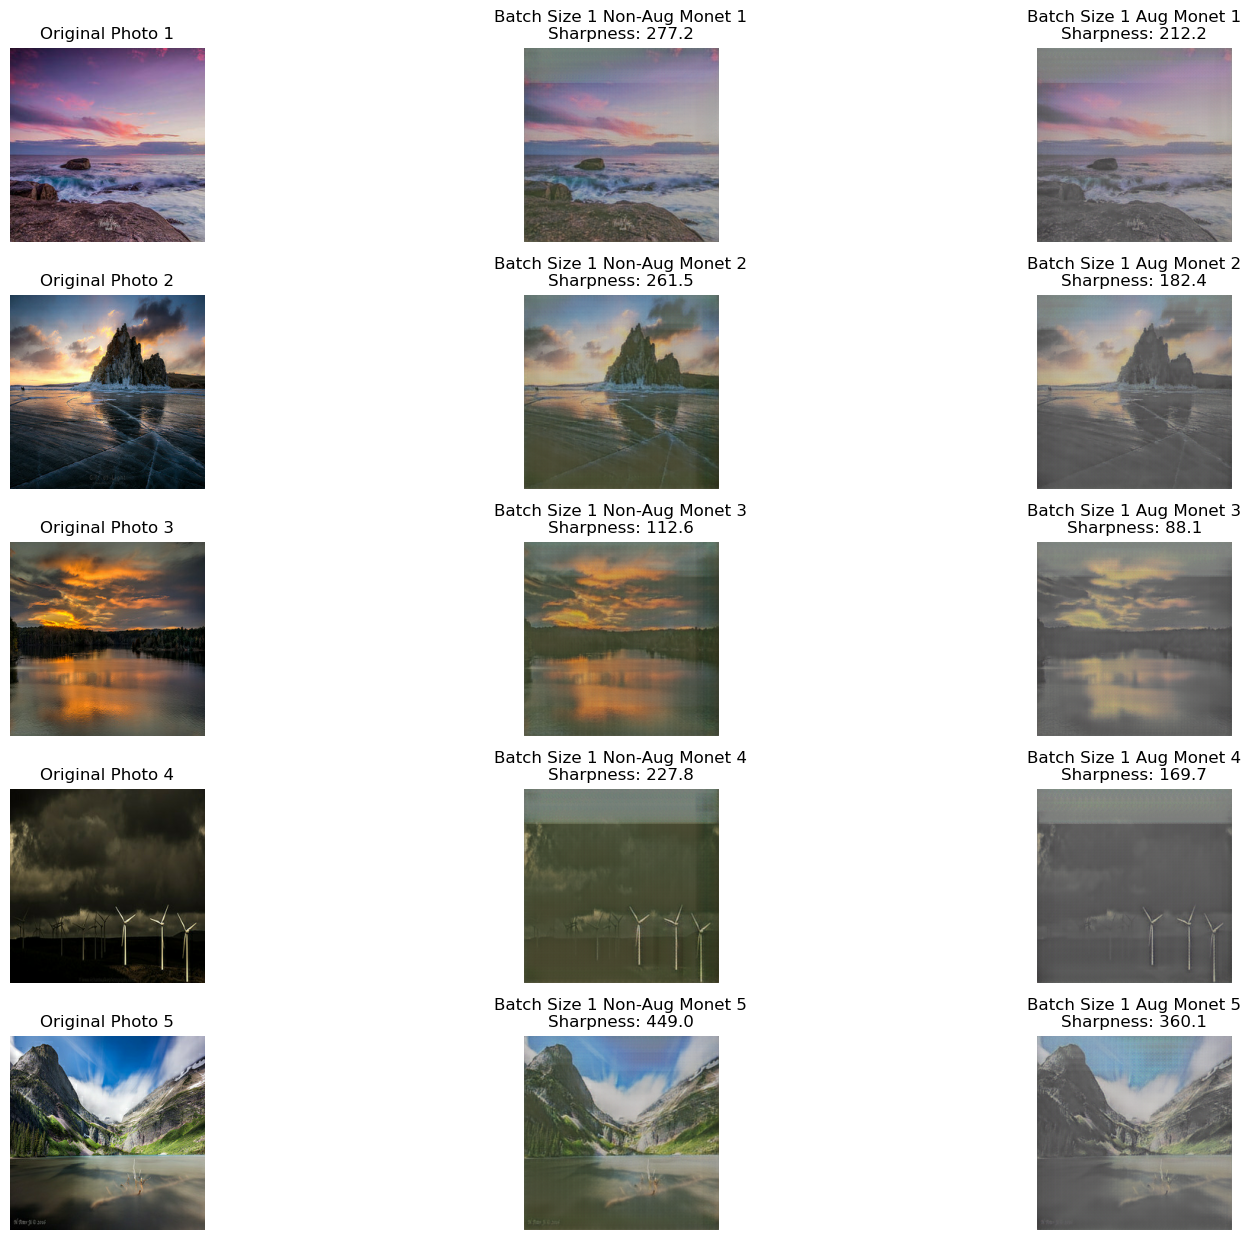


 Average Sharpness:
- Batch Size 1 Non-Augmented: 265.62
- Batch Size 1 Augmented: 202.51


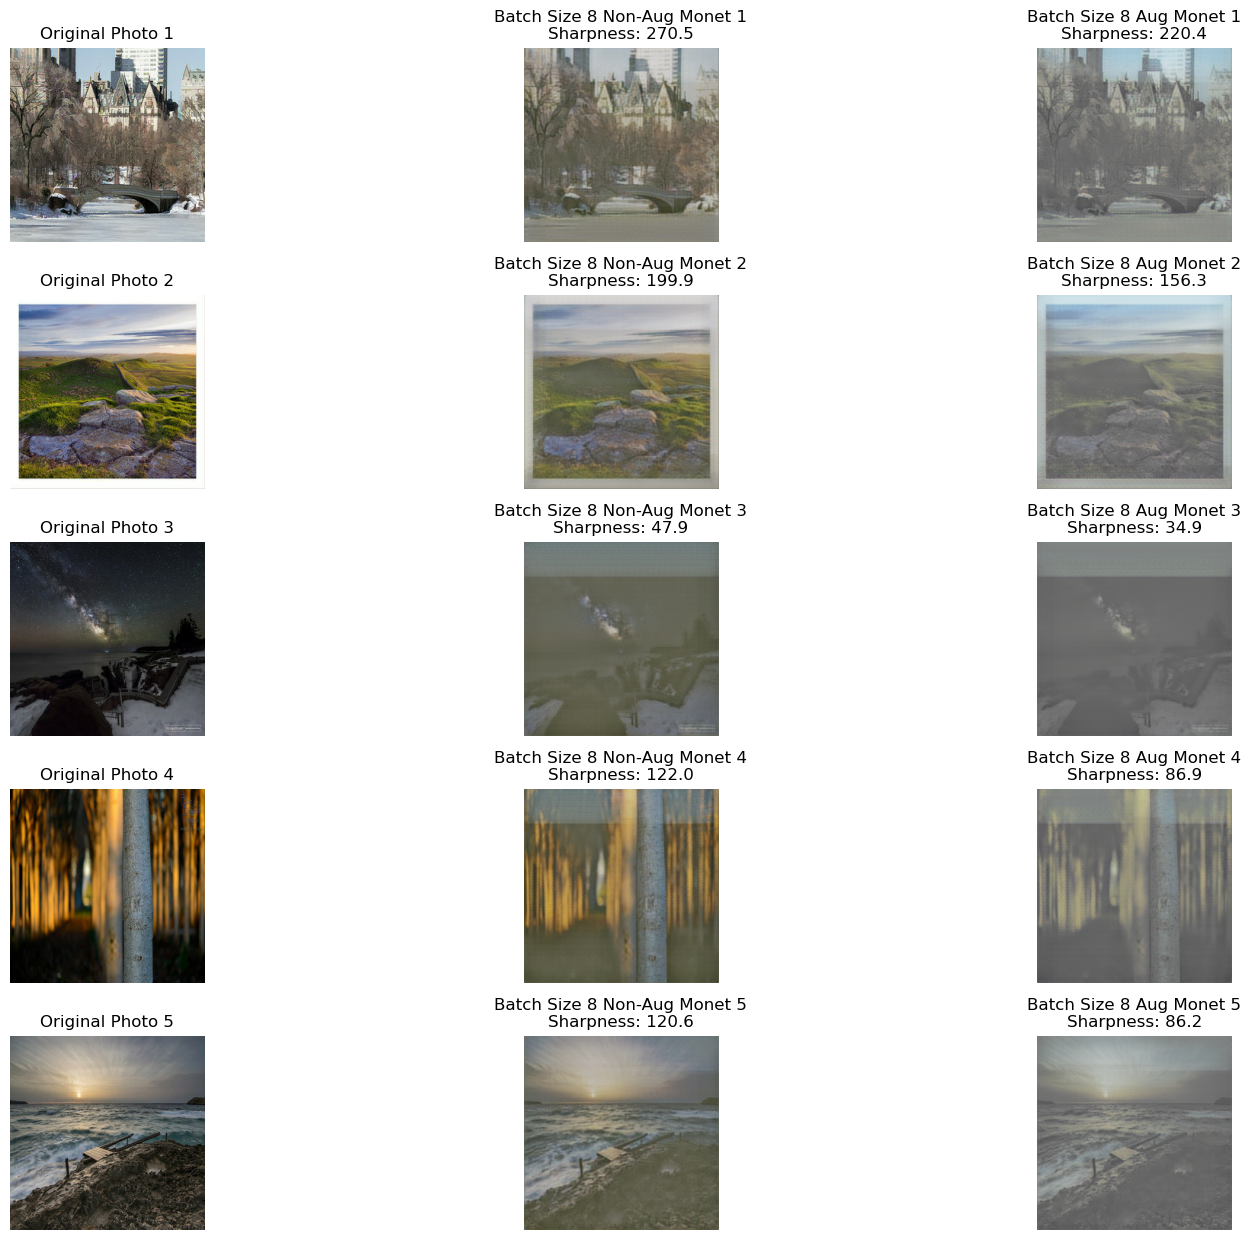


 Average Sharpness:
- Batch Size 8 Non-Augmented: 152.14
- Batch Size 8 Augmented: 116.94


In [ ]:
sharpness_bs1_nonaug, sharpness_bs1_aug = display_photo_to_monet_comparison_with_sharpness(
    gen_batchsize1,
    gen_batchsize1_with_aug,
    photo_train_batchsize1,
    num_images=5,
    title_prefix="Batch Size 1"
)

sharpness_bs8_nonaug, sharpness_bs8_aug = display_photo_to_monet_comparison_with_sharpness(
    gen_batchsize8,
    gen_batchsize8_with_aug,
    photo_train_batchsize8,
    num_images=5,
    title_prefix="Batch Size 8"
)


# 6 Final Model

In this final evaluation phase, the models were assessed based on both their training losses and the sharpness of the generated images. The key factors considered in the evaluation were the Generator Loss, Discriminator Loss, and Sharpness, with the goal of determining the most balanced and effective model.

The loss files for each configuration (batch size 1 with and without augmentation, and batch size 8 with and without augmentation) were analyzed, with the final generator and discriminator losses calculated as the average of the last 10 epochs. These losses were then normalized and inverted so that lower values corresponded to better performance. Sharpness scores, obtained from previous experiments, were also factored in, with higher sharpness values considered better.

A combined score was calculated for each model by summing the normalized scores for generator loss, discriminator loss, and sharpness. The models were then ranked based on this total score.

In [ ]:
loss_files = {
    'BatchSize1_NonAug': 'training_losses_batchsize1.csv',
    'BatchSize1_Aug': 'training_losses_batchsize1_with_aug.csv',
    'BatchSize8_NonAug': 'training_losses_batchsize8.csv',
    'BatchSize8_Aug': 'training_losses_batchsize8_with_aug.csv',
}

loss_data = {}

for name, file in loss_files.items():
    df = pd.read_csv(file)
    gen_loss = df[['Generator Loss A->B', 'Generator Loss B->A']].mean(axis=1)
    disc_loss = df[['Discriminator Loss A', 'Discriminator Loss B']].mean(axis=1)
    loss_data[name] = {
        'Final_Gen_Loss': gen_loss.iloc[-10:].mean(),  # average of last 10 epochs
        'Final_Disc_Loss': disc_loss.iloc[-10:].mean()
    }

sharpness_scores = {
    'BatchSize1_NonAug': sharpness_bs1_nonaug,
    'BatchSize1_Aug': sharpness_bs1_aug,
    'BatchSize8_NonAug': sharpness_bs8_nonaug,
    'BatchSize8_Aug': sharpness_bs8_aug,
}

combined_scores = []

max_sharpness = max(sharpness_scores.values()) if sharpness_scores else 1

for model in loss_data.keys():
    loss = loss_data[model]
    sharpness = sharpness_scores.get(model, 0)

    # Lower Generator and Discriminator Losses are better so they are inverted
    gen_loss_score = 5 - min(max(loss['Final_Gen_Loss'] / 5.0, 0), 5)
    disc_loss_score = 5 - min(max(loss['Final_Disc_Loss'] / 5.0, 0), 5)

    # Sharpness: higher is better, normalized
    sharpness_score = (sharpness / max_sharpness) * 5

    # Total combined score
    total_score = gen_loss_score + disc_loss_score + sharpness_score

    combined_scores.append({
        'Model': model,
        'Total_Score': total_score,
        'Breakdown': {
            'Generator Loss Score': gen_loss_score,
            'Discriminator Loss Score': disc_loss_score,
            'Sharpness Score': sharpness_score,
            'Raw Sharpness': sharpness,
            'Final Generator Loss': loss['Final_Gen_Loss'],
            'Final Discriminator Loss': loss['Final_Disc_Loss'],
        }
    })

sorted_models = sorted(combined_scores, key=lambda x: x['Total_Score'], reverse=True)

print("\n Model Rankings:")
for rank, model_info in enumerate(sorted_models, 1):
    print(f"{rank}. {model_info['Model']} — Total Score: {model_info['Total_Score']:.2f}")
    for k, v in model_info['Breakdown'].items():
        if isinstance(v, float):
            print(f"    {k}: {v:.2f}")
        else:
            print(f"    {k}: {v}")
    print()



 Model Rankings:
1. BatchSize1_NonAug — Total Score: 13.73
    Generator Loss Score: 3.74
    Discriminator Loss Score: 4.99
    Sharpness Score: 5.00
    Raw Sharpness: 265.62
    Final Generator Loss: 6.28
    Final Discriminator Loss: 0.05

2. BatchSize1_Aug — Total Score: 12.58
    Generator Loss Score: 3.77
    Discriminator Loss Score: 5.00
    Sharpness Score: 3.81
    Raw Sharpness: 202.51
    Final Generator Loss: 6.16
    Final Discriminator Loss: 0.00

3. BatchSize8_NonAug — Total Score: 11.59
    Generator Loss Score: 3.73
    Discriminator Loss Score: 5.00
    Sharpness Score: 2.86
    Raw Sharpness: 152.14
    Final Generator Loss: 6.35
    Final Discriminator Loss: 0.00

4. BatchSize8_Aug — Total Score: 10.95
    Generator Loss Score: 3.75
    Discriminator Loss Score: 5.00
    Sharpness Score: 2.20
    Raw Sharpness: 116.94
    Final Generator Loss: 6.24
    Final Discriminator Loss: 0.01



In [ ]:
import zipfile
from PIL import Image

def generate_and_save_images(generator, photo_dataset, num_images=7028, output_dir='generated_images'):
    os.makedirs(output_dir, exist_ok=True)  # Create directory to save images

    photo_iter = iter(photo_dataset)  # Use the same dataset for both batch sizes

    for i in range(num_images):
        try:
            # Get the photo
            photo = next(photo_iter)
        except StopIteration:
            break  # Stop if dataset is exhausted

        # Generate Monet-style image
        monetized_photo = generator(photo, training=False)

        # Resize the generated image to 256x256
        monetized_photo_resized = tf.image.resize(monetized_photo, (256, 256))

        # Convert tensor to numpy array
        monetized_photo_resized_np = (monetized_photo_resized[0].numpy() + 1) / 2  # Rescale from [-1, 1] to [0, 1]

        # Convert to PIL Image to save as JPEG
        image_filename = os.path.join(output_dir, f"generated_image_{i + 1}.jpeg")
        pil_image = Image.fromarray((monetized_photo_resized_np * 255).astype(np.uint8))  # Convert to [0, 255]
        pil_image.save(image_filename, 'JPEG', quality=95)  # Save as JPEG with quality 95 (default is 75)

# Function to zip the generated images
def create_zip_from_images(zip_filename='images.zip', output_dir='generated_images'):
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(output_dir):
            for file in files:
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), output_dir))
        print(f"Created zip file: {zip_filename}")

# Generate and save all 7028 images
generate_and_save_images(gen_batchsize1, photo_train_batchsize1, num_images=7028)

# Create zip from saved images
create_zip_from_images('images.zip')


Created zip file: images.zip
